# Definitions

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
os.environ['OMP_NUM_THREADS'] = '12'
import matplotlib
import math
from matplotlib import pyplot as plt
import numpy as np
import euclidemu2
import scipy
import cosmolike_lsst_y1_interface as ci
from getdist import IniFile
import itertools
import iminuit
import functools
print(sys.version)
print(os.getcwd())

# GENERAL PLOT OPTIONS
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['xtick.bottom'] = True
matplotlib.rcParams['xtick.top'] = False
matplotlib.rcParams['ytick.right'] = False
matplotlib.rcParams['axes.edgecolor'] = 'black'
matplotlib.rcParams['axes.linewidth'] = '1.0'
matplotlib.rcParams['axes.labelsize'] = 'medium'
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.linewidth'] = '0.0'
matplotlib.rcParams['grid.alpha'] = '0.18'
matplotlib.rcParams['grid.color'] = 'lightgray'
matplotlib.rcParams['legend.labelspacing'] = 0.77
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['savefig.format'] = 'pdf'
matplotlib.rcParams['text.usetex'] = True

# Jupyter Notebook Display options
import IPython
IPython.display.display(IPython.display.HTML("<style>:root { --jp-notebook-max-width: 85% !important; }</style>"))
IPython.display.display(IPython.display.HTML("<style>div.output_scroll { height: 54em; }</style>"))

3.9.19 | packaged by conda-forge | (main, Mar 20 2024, 12:50:21) 
[GCC 12.3.0]
/home/vivianmiranda/extra_data/Vivian/cocoa2025/cocoa/Cocoa/projects/des_y3


In [2]:
# IMPORT CAMB
sys.path.insert(0, os.environ['ROOTDIR']+'/external_modules/code/CAMB/build/lib.linux-x86_64-'+os.environ['PYTHON_VERSION'])
import camb
from camb import model
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.5.5 installed at /home/vivianmiranda/extra_data/Vivian/cocoa2025/cocoa/Cocoa/external_modules/code/CAMB/build/lib.linux-x86_64-3.9/camb


In [3]:
CAMBAccuracyBoost = 1.1
non_linear_emul = 2
CLprobe="xi"

path= "../../external_modules/data/des_y3"
data_file="des_y3_real.dataset"

IA_model = 1
IA_redshift_evolution = 3

ntheta = 20 
theta_min_arcmin = 2.5 
theta_max_arcmin = 250 

In [4]:
As_1e9 = 2.1
ns = 0.96605
H0 = 67.32
omegab = 0.04
omegam = 0.3
mnu = 0.06
DES_DZ_S1 = 0.0414632
DES_DZ_S2 = 0.00147332
DES_DZ_S3 = 0.0237035
DES_DZ_S4 = -0.0773436
DES_M1 = 0.0191832
DES_M2 = -0.0431752
DES_M3 = -0.034961
DES_M4 = -0.0158096
DES_A1_1 = 0.606102
DES_A1_2 = -1.51541
DES_A2_1 = -1.7938938475734911 
DES_A2_2 = -1.5448080290038528
DES_BTA_1 = 0.8154011496506723
w0pwa = -0.9
w = -0.9

In [5]:
def get_camb_cosmology(omegam = omegam, 
                       omegab = omegab, 
                       H0 = H0, 
                       ns = ns, 
                       As_1e9 = As_1e9, 
                       w = w, 
                       w0pwa = w0pwa, 
                       AccuracyBoost = 1.0, 
                       kmax = 10, 
                       k_per_logint = 20, 
                       CAMBAccuracyBoost=1.1):

    As = lambda As_1e9: 1e-9 * As_1e9
    wa = lambda w0pwa, w: w0pwa - w
    omegabh2 = lambda omegab, H0: omegab*(H0/100)**2
    omegach2 = lambda omegam, omegab, mnu, H0: (omegam-omegab)*(H0/100)**2-(mnu*(3.046/3)**0.75)/94.0708
    omegamh2 = lambda omegam, H0: omegam*(H0/100)**2

    CAMBAccuracyBoost = CAMBAccuracyBoost*AccuracyBoost
    kmax = max(kmax/2.0, kmax*(1.0 + 3*(AccuracyBoost-1)))
    k_per_logint = max(k_per_logint/2.0, int(k_per_logint) + int(3*(AccuracyBoost-1)))
    extrap_kmax = max(max(2.5e2, 3*kmax), max(2.5e2, 3*kmax) * AccuracyBoost)

    z_interp_1D = np.concatenate( (np.concatenate( (np.linspace(0,2.0,1000),
                                                    np.linspace(2.0,10.1,200)),
                                                    axis=0
                                                 ),
                                   np.linspace(1080,2000,20)),
                                   axis=0)
    
    z_interp_2D = np.concatenate((np.linspace(0, 2.0, 130),np.linspace(2.25, 10, 50)),  axis=0)
    log10k_interp_2D = np.linspace(-4.2, 2.0, 1400)

    pars = camb.set_params(H0=H0, 
                           ombh2=omegabh2(omegab, H0), 
                           omch2=omegach2(omegam, omegab, mnu, H0), 
                           mnu=mnu, 
                           omk=0, 
                           tau=0.06,  
                           As=As(As_1e9), 
                           ns=ns, 
                           halofit_version='takahashi', 
                           lmax=10,
                           AccuracyBoost=CAMBAccuracyBoost,
                           lens_potential_accuracy=1.0,
                           num_massive_neutrinos=1,
                           nnu=3.046,
                           accurate_massive_neutrino_transfers=False,
                           k_per_logint=k_per_logint,
                           kmax = kmax);
    
    pars.set_dark_energy(w=w, wa=wa(w0pwa, w), dark_energy_model='ppf');    
    
    pars.NonLinear = model.NonLinear_both
    
    pars.set_matter_power(redshifts = z_interp_2D, kmax = kmax, silent = True);
    results = camb.get_results(pars)
    
    PKL  = results.get_matter_power_interpolator(var1="delta_tot", var2="delta_tot", nonlinear = False, 
                                                 extrap_kmax = extrap_kmax, hubble_units = False, k_hunit = False);
    
    PKNL = results.get_matter_power_interpolator(var1="delta_tot", var2="delta_tot",  nonlinear = True, 
                                                 extrap_kmax = extrap_kmax, hubble_units = False, k_hunit = False);
    
    lnPL = np.empty(len(log10k_interp_2D)*len(z_interp_2D))
    for i in range(len(z_interp_2D)):
        lnPL[i::len(z_interp_2D)] = np.log(PKL.P(z_interp_2D[i], np.power(10.0,log10k_interp_2D)))
    lnPL  += np.log(((H0/100.)**3)) 
    
    lnPNL  = np.empty(len(log10k_interp_2D)*len(z_interp_2D))
    if non_linear_emul == 1:
        params = { 'Omm'  : omegam, 
                   'As'   : As(As_1e9), 
                   'Omb'  : omegab,
                   'ns'   : ns, 
                   'h'    : H0/100., 
                   'mnu'  : mnu,  
                   'w'    : w, 
                   'wa'   : wa(w0pwa, w)
                 }
        kbt, bt = euclidemu2.get_boost( params, 
                                        z_interp_2D, 
                                        np.power(10.0, np.linspace( -2.0589, 0.973, len(log10k_interp_2D)))
                                      )
        log10k_interp_2D = log10k_interp_2D - np.log10(H0/100.)
        
        for i in range(len(z_interp_2D)):    
            lnbt = scipy.interpolate.interp1d(np.log10(kbt), np.log(bt[i]), kind = 'linear', 
                                              fill_value = 'extrapolate', 
                                              assume_sorted = True)(log10k_interp_2D)
            lnbt[np.power(10,log10k_interp_2D) < 8.73e-3] = 0.0
            lnPNL[i::len(z_interp_2D)]  = lnPL[i::len(z_interp_2D)] + lnbt
    elif non_linear_emul == 2:
        for i in range(len(z_interp_2D)):
            lnPNL[i::len(z_interp_2D)] = np.log(PKNL.P(z_interp_2D[i], np.power(10.0, log10k_interp_2D)))            
        log10k_interp_2D = log10k_interp_2D - np.log10(H0/100.)
        lnPNL += np.log(((H0/100.)**3))

    G_growth = np.sqrt(PKL.P(z_interp_2D,0.0005)/PKL.P(0,0.0005))
    G_growth = G_growth*(1 + z_interp_2D)
    G_growth = G_growth/G_growth[len(G_growth)-1]
    
    chi = results.comoving_radial_distance(z_interp_1D, tol=1e-4) * (H0/100.)

    return (log10k_interp_2D, z_interp_2D, lnPL, lnPNL, G_growth, z_interp_1D, chi)

In [6]:
def C_ss_tomo_limber(ell, 
                     omegam = omegam, 
                     omegab = omegab, 
                     H0 = H0, 
                     ns = ns, 
                     As_1e9 = As_1e9, 
                     w = w, 
                     w0pwa = w0pwa,
                     A1  = [DES_A1_1, DES_A1_2, 0, 0], 
                     A2  = [DES_A2_1, DES_A2_2, 0, 0],
                     BTA = [DES_BTA_1, 0, 0, 0],
                     shear_photoz_bias = [DES_DZ_S1, DES_DZ_S2, DES_DZ_S3, DES_DZ_S4],
                     M = [DES_M1, DES_M2, DES_M3, DES_M4],
                     baryon_sims = None,
                     AccuracyBoost = 1.0, 
                     kmax = 10, 
                     k_per_logint = 20, 
                     CAMBAccuracyBoost=1.1,
                     CLAccuracyBoost = 1.0, 
                     CLIntegrationAccuracy = 1):

    (log10k_interp_2D, z_interp_2D, lnPL, lnPNL, G_growth, z_interp_1D, chi) = get_camb_cosmology(omegam=omegam, 
        omegab=omegab, H0=H0, ns=ns, As_1e9=As_1e9, w=w, w0pwa=w0pwa, AccuracyBoost=AccuracyBoost, kmax=kmax,
        k_per_logint=k_per_logint, CAMBAccuracyBoost=CAMBAccuracyBoost)

    CLAccuracyBoost = CLAccuracyBoost * AccuracyBoost
    CLSamplingBoost = CLAccuracyBoost * AccuracyBoost
    CLIntegrationAccuracy = max(0, CLIntegrationAccuracy + 3*(AccuracyBoost-1.0))
    ci.init_accuracy_boost(1.0, CLSamplingBoost, int(CLIntegrationAccuracy))

    ci.set_cosmology(omegam = omegam, 
                     H0 = H0, 
                     log10k_2D = log10k_interp_2D, 
                     z_2D = z_interp_2D, 
                     lnP_linear = lnPL,
                     lnP_nonlinear = lnPNL,
                     G = G_growth,
                     z_1D = z_interp_1D,
                     chi = chi)
    ci.set_nuisance_shear_calib(M = M)
    ci.set_nuisance_shear_photoz(bias = shear_photoz_bias)
    ci.set_nuisance_ia(A1 = A1, A2 = A2, B_TA = BTA)

    if baryon_sims is None:
        ci.reset_bary_struct()
    else:
        ci.init_baryons_contamination(sim = baryon_sims)
        
    return ci.C_ss_tomo_limber(l = ell)

In [7]:
def xi(ntheta = ntheta, 
       theta_min_arcmin = theta_min_arcmin, 
       theta_max_arcmin = theta_max_arcmin, 
       omegam = omegam, 
       omegab = omegab, 
       H0 = H0, 
       ns = ns, 
       As_1e9 = As_1e9, 
       w = w, 
       w0pwa = w0pwa,
       A1  = [DES_A1_1, DES_A1_2, 0.0, 0.0], 
       A2  = [DES_A2_1, DES_A2_2, 0.0, 0.0],
       BTA = [DES_BTA_1, 0, 0, 0.0, 0.0],     
       shear_photoz_bias = [DES_DZ_S1, DES_DZ_S2, DES_DZ_S3, DES_DZ_S4],
       M = [DES_M1, DES_M2, DES_M3, DES_M4],
       baryon_sims = None,
       AccuracyBoost = 1.0, 
       kmax = 10, 
       k_per_logint = 20, 
       CAMBAccuracyBoost=1.1,
       CLAccuracyBoost = 1.0, 
       CLIntegrationAccuracy = 1):

    (log10k_interp_2D, z_interp_2D, lnPL, lnPNL, G_growth, z_interp_1D, chi) = get_camb_cosmology(omegam=omegam, 
        omegab=omegab, H0=H0, ns=ns, As_1e9=As_1e9, w=w, w0pwa=w0pwa, AccuracyBoost=AccuracyBoost, kmax=kmax,
        k_per_logint=k_per_logint, CAMBAccuracyBoost=CAMBAccuracyBoost)

    CLAccuracyBoost = CLAccuracyBoost * AccuracyBoost
    CLSamplingBoost = CLAccuracyBoost * AccuracyBoost
    CLIntegrationAccuracy = max(0, CLIntegrationAccuracy + 5*(AccuracyBoost-1.0))
    ci.init_accuracy_boost(1.0, CLAccuracyBoost, int(CLIntegrationAccuracy))
    
    ci.init_binning(int(ntheta), theta_min_arcmin, theta_max_arcmin)
    
    ci.set_cosmology(omegam = omegam, 
                     H0 = H0, 
                     log10k_2D = log10k_interp_2D, 
                     z_2D = z_interp_2D, 
                     lnP_linear = lnPL,
                     lnP_nonlinear = lnPNL,
                     G = G_growth,
                     z_1D = z_interp_1D,
                     chi = chi)
    ci.set_nuisance_shear_calib(M = M)
    ci.set_nuisance_shear_photoz(bias = shear_photoz_bias)
    ci.set_nuisance_ia(A1 = A1, A2 = A2, B_TA = BTA)

    if baryon_sims is None:
        ci.reset_bary_struct()
    else:
        ci.init_baryons_contamination(sim = baryon_sims)
        
    (xip, xim) = ci.xi_pm_tomo()    
    return (ci.get_binning_real_space(), xip, xim)

In [8]:
def plot_C_ss_tomo_limber(ell, C_ss, C_ss_ref = None, param = None, colorbarlabel = None, lmin = 30, lmax = 1500, 
                          cmap = 'gist_rainbow', ylim = [0.75,1.25], linestyle = None, linewidth = None,
                          legend = None, legendloc = (0.6,0.78), yaxislabelsize = 16, yaxisticklabelsize = 10, 
                          xaxisticklabelsize = 20, bintextpos = [0.2, 0.85], bintextsize = 15, figsize = (12, 12), 
                          show = 1):

    nell, ntomo, ntomo2 = C_ss[0].shape
    if ntomo != ntomo2:
        print("Bad Input (ntomo)")
        return 0
      
    if nell != len(ell):
        print("Bad Input (number of ell)")
        return 0
    if not (C_ss_ref is None):
        nell2, ntomo3, ntomo4 = C_ss_ref.shape
        if (ntomo3 != ntomo4) or (nell != nell2):
            print(f"notomo = {ntomo}, ntomo_REF = {ntomo3}")
            print(f"Nell = {nell}, Nell_REF = {nell2}")
            return 0   
        
    if C_ss_ref is None:
        fig, axes = plt.subplots(
            nrows = ntomo, 
            ncols = ntomo, 
            figsize = figsize, 
            sharex = True, 
            sharey = False, 
            gridspec_kw = {'wspace': 0.25, 'hspace': 0.05})
    else:
        fig, axes = plt.subplots(
            nrows = ntomo, 
            ncols = ntomo, 
            figsize = figsize, 
            sharex = True, 
            sharey = True, 
            gridspec_kw = {'wspace': 0, 'hspace': 0})
    
    cm = plt.get_cmap(cmap)
    
    if not (param is None):
        cb = fig.colorbar(
            matplotlib.cm.ScalarMappable(norm = matplotlib.colors.Normalize(param[0], param[-1]), cmap = 'gist_rainbow'), 
            ax = axes.ravel().tolist(), 
            orientation = 'vertical', 
            aspect = 50, 
            pad = -0.16, 
            shrink = 0.4)
        if not (colorbarlabel is None):
            cb.set_label(label = colorbarlabel, size = 20, weight = 'bold', labelpad = 2)
        if len(param) != len(C_ss):
            print("Bad Input")
            return 0

    if not (linestyle is None):
        linestylecycler = itertools.cycle(linestyle)
    else:
        linestylecycler = itertools.cycle(['solid'])

    if not (linewidth is None):
        linewidthcycler = itertools.cycle(linewidth)
    else:
        linewidthcycler = itertools.cycle([1.0])
    
    for i in range(ntomo):
        for j in range(ntomo):
            if i>j:                
                axes[j,i].axis('off')
            else:
                clmin = []
                clmax = []
                for Cl in C_ss:  
                    tmp = ell * (ell + 1) * Cl[:,i,j] / (2 * math.pi)
                    clmin.append(np.min(tmp))
                    clmax.append(np.max(tmp))
     
                axes[j,i].set_xlim([lmin, lmax])
                
                if C_ss_ref is None:
                    axes[j,i].set_ylim([np.min(ylim[0]*np.array(clmin)), np.max(ylim[1]*np.array(clmax))])
                    axes[j,i].set_yscale('log')
                else:
                    tmp = np.array(ylim) - 1
                    axes[j,i].set_ylim(tmp.tolist())
                    axes[j,i].set_yscale('linear')
                    
                axes[j,i].set_xscale('log')
                
                if i == 0:
                    if C_ss_ref is None:
                        axes[j,i].set_ylabel("$\ell (\ell+1) C_{\ell}^{EE}/(2 \pi)$", fontsize=yaxislabelsize)
                    else:
                        axes[j,i].set_ylabel("frac. diff.", fontsize=yaxislabelsize)
                for item in (axes[j,i].get_yticklabels()):
                    item.set_fontsize(yaxisticklabelsize)
                for item in (axes[j,i].get_xticklabels()):
                    item.set_fontsize(xaxisticklabelsize)
                
                if j == 4:
                    axes[j,i].set_xlabel(r"$\ell$", fontsize=16)
                
                axes[j,i].text(bintextpos[0], bintextpos[1], 
                    "$(" +  str(i) + "," +  str(j) + ")$", 
                    horizontalalignment = 'center', 
                    verticalalignment = 'center',
                    fontsize = bintextsize,
                    usetex = True,
                    transform = axes[j,i].transAxes)
                
                for x, Cl in enumerate(C_ss):
                    if C_ss_ref is None:
                        tmp = ell * (ell + 1) * Cl[:,i,j] / (2 * math.pi)
                    else:
                        tmp = Cl[:,i,j] / C_ss_ref[:,i,j] - 1
                    lines = axes[j,i].plot(ell, tmp, 
                                           color=cm(x/len(C_ss)), 
                                           linewidth=next(linewidthcycler), 
                                           linestyle=next(linestylecycler))
    
    if not (legend is None):
        if len(legend) != len(C_ss):
            print("Bad Input")
            return 0
        fig.legend(
            legend, 
            loc=legendloc,
            borderpad=0.1,
            handletextpad=0.4,
            handlelength=1.5,
            columnspacing=0.35,
            scatteryoffsets=[0],
            frameon=False)

    if not (show is None):
        fig.show()
    else:
        return (fig, axes)

In [9]:
def plot_xi(pm, xi, xi_ref = None, param = None, colorbarlabel = None, marker = None, 
                linestyle = None, linewidth = None, ylim = [0.88,1.12], 
                cmap = 'gist_rainbow', legend = None, legendloc = (0.6,0.78), yaxislabelsize = 16, 
                yaxisticklabelsize = 10, xaxisticklabelsize = 20, bintextpos = [[0.8, 0.875],[0.2,0.875]], 
                bintextsize = 15, figsize = (12, 12), show = 1, thetashow=[3,250]):
    
    (theta, xip, xim) = xi[0]
    (ntheta, ntomo, ntomo2) = xip.shape    

    if ntomo != ntomo2:
        print("Bad Input (ntomo)")
        return 0
            
    if ntheta != len(theta):
        print("Bad Input (theta)")
        return 0

    if xi_ref is None:
        fig, axes = plt.subplots(
            nrows = ntomo, 
            ncols = ntomo, 
            figsize = figsize, 
            sharex = True, 
            sharey = False, 
            gridspec_kw = {'wspace': 0.25, 'hspace': 0.05}
        )
    else:
        fig, axes = plt.subplots(
            nrows = ntomo, 
            ncols = ntomo, 
            figsize = figsize, 
            sharex = True, 
            sharey = True, 
            gridspec_kw = {'wspace': 0.0, 'hspace': 0.0}
        )    

    cm = plt.get_cmap(cmap)

    if not (param is None):
        cb = fig.colorbar(
            matplotlib.cm.ScalarMappable(norm = matplotlib.colors.Normalize(param[0], param[-1]), cmap = 'gist_rainbow'), 
            ax = axes.ravel().tolist(), 
            orientation = 'vertical', 
            aspect = 50, 
            pad = -0.16, 
            shrink = 0.3
        )
        if not (colorbarlabel is None):
            cb.set_label(label = colorbarlabel, size = 20, weight = 'bold', labelpad = 2)
        if len(param) != len(xi):
            print("Bad Input")
            return 0

    if not (marker is None):
        markercycler = itertools.cycle(marker)
    
    if not (linestyle is None):
        linestylecycler = itertools.cycle(linestyle)
    else:
        linestylecycler = itertools.cycle(['solid'])
    
    if not (linewidth is None):
        linewidthcycler = itertools.cycle(linewidth)
    else:
        linewidthcycler = itertools.cycle([1.0])
        
    for i in range(ntomo):
        for j in range(ntomo):
            if i>j:                
                axes[j,i].axis('off')
            else:
                ximin = []
                ximax = []
                for (theta, xip, xim) in xi:
                    if pm > 0:
                        ximin.append(np.min(theta*xip[:,i,j]*10**4))
                        ximax.append(np.max(theta*xip[:,i,j]*10**4))
                    else:
                        ximin.append(np.min(theta*xim[:,i,j]*10**4))
                        ximax.append(np.max(theta*xim[:,i,j]*10**4))
                        
                axes[j,i].set_xlim(thetashow)
                
                if xi_ref is None:
                    axes[j,i].set_ylim([np.min(ylim[0]*np.array(ximin)), np.max(ylim[1]*np.array(ximax))])
                else:
                    tmp = np.array(ylim) - 1
                    axes[j,i].set_ylim(tmp.tolist())
                axes[j,i].set_xscale('log')
                axes[j,i].set_yscale('linear')
                
                if i == 0:
                    if xi_ref is None:
                        if pm > 0:
                            axes[j,i].set_ylabel(r"$\theta \xi_{+} \times 10^4$", fontsize=yaxislabelsize)
                        else:
                            axes[j,i].set_ylabel(r"$\theta \xi_{-} \times 10^4$", fontsize=yaxislabelsize)
                    else:
                        if pm > 0:
                            axes[j,i].set_ylabel(r"frac. diff. ($\xi_{+})$", fontsize=yaxislabelsize)
                        else:
                            axes[j,i].set_ylabel(r"frac. diff. ($\xi_{-})$", fontsize=yaxislabelsize)

                if j == ntomo-1:
                    axes[j,i].set_xlabel(r"$\theta$ [arcmin]", fontsize=16)
                for item in (axes[j,i].get_yticklabels()):
                    item.set_fontsize(yaxisticklabelsize)
                for item in (axes[j,i].get_xticklabels()):
                    item.set_fontsize(xaxisticklabelsize)

                if pm > 0:
                    axes[j,i].text(bintextpos[0][0], 
                                   bintextpos[0][1], 
                                   "$(" +  str(i) + "," +  str(j) + ")$", 
                                   horizontalalignment='center', 
                                   verticalalignment='center',
                                   fontsize=bintextsize,
                                   usetex=True,
                                   transform=axes[j,i].transAxes)
                else:
                    axes[j,i].text(bintextpos[1][0], 
                                   bintextpos[1][1], 
                                   "$(" +  str(i) + "," +  str(j) + ")$", 
                                   horizontalalignment='center', 
                                   verticalalignment='center',
                                   fontsize=15,
                                   usetex=True,
                                   transform=axes[j,i].transAxes)

                if xi_ref is None:
                    for x, (theta, xip, xim) in enumerate(xi):
                        if pm > 0:
                            if marker is None:
                                axes[j,i].plot(theta, theta*xip[:,i,j]*10**4, color=cm(x/len(xi)), 
                                               linewidth=next(linewidthcycler), linestyle=next(linestylecycler))
                            else:
                                axes[j,i].plot(theta, theta*xip[:,i,j]*10**4, color=cm(x/len(xi)), 
                                               markerfacecolor='None', marker=next(markercycler), 
                                               markeredgecolor=cm(x/len(xi)), linestyle='None', markersize=3)
                        else:
                            if marker is None:   
                                axes[j,i].plot(theta, theta*xim[:,i,j]*10**4, color=cm(x/len(xi)), 
                                    linewidth=next(linewidthcycler), linestyle=next(linestylecycler))
                            else:
                                axes[j,i].plot(theta, theta*xim[:,i,j]*10**4, color=cm(x/len(xi)), 
                                               markerfacecolor='None', marker=next(markercycler), 
                                               markeredgecolor=cm(x/len(xi)), linestyle='None', markersize=3)
                else:
                    (theta_ref, xip_ref, xim_ref) = xi_ref
                    for x, (theta, xip, xim) in enumerate(xi):
                        if theta != theta_ref:
                            print("inconsistent theta bins")
                            return 0
                        if pm > 0:
                            if marker is None:
                                axes[j,i].plot(theta, xip[:,i,j]/xip_ref[:,i,j]-1.0, color=cm(x/len(xi)), 
                                               linewidth=next(linewidthcycler), linestyle=next(linestylecycler))
                            else:
                                axes[j,i].plot(theta, xip[:,i,j]/xip_ref[:,i,j]-1.0, 
                                               color=cm(x/len(xi)), markerfacecolor='None',
                                               marker=next(markercycler),  markeredgecolor=cm(x/len(xi)), 
                                               linestyle='None', markersize=3)
                        else:
                            if marker is None:   
                                lines = axes[j,i].plot(theta, xip[:,i,j]/xip_ref[:,i,j]-1.0, color=cm(x/len(xi)), 
                                                       linewidth=next(linewidthcycler), linestyle=next(linestylecycler))
                            else:
                                axes[j,i].plot(theta, xip[:,i,j]/xip_ref[:,i,j]-1.0, color=cm(x/len(xi)), 
                                               markerfacecolor='None', marker=next(markercycler), 
                                               markeredgecolor=cm(x/len(xi)), 
                                               linestyle='None', markersize=3)    
    if not (legend is None):
        if len(legend) != len(xi):
            print("Bad Input")
            return 0
        fig.legend(legend, 
                   loc=legendloc,
                   borderpad=0.1,
                   handletextpad=0.4,
                   handlelength=1.5,
                   columnspacing=0.35,
                   scatteryoffsets=[0],
                   frameon=False)  
    if not (show is None):
        fig.show()
    else:
        return (fig, axes)

In [10]:
# Init Cosmolike
ini = IniFile(os.path.normpath(os.path.join(path, data_file)))

lens_file = ini.relativeFileName('nz_lens_file')
source_file = ini.relativeFileName('nz_source_file')
lens_ntomo = ini.int("lens_ntomo")
source_ntomo = ini.int("source_ntomo")

ci.initial_setup()

ci.init_accuracy_boost(1.0, 1.0, int(1))

ci.init_cosmo_runmode(is_linear = False)

ci.init_redshift_distributions_from_files(
      lens_multihisto_file=lens_file,
      lens_ntomo=int(lens_ntomo), 
      source_multihisto_file=source_file,
      source_ntomo=int(source_ntomo))

ci.init_IA( ia_model = int(IA_model), 
            ia_redshift_evolution = int(IA_redshift_evolution))

# Let's plot how cosmological and nuisance parameters affect $C_{\ell}^{EE}$

In [11]:
ell = np.arange(25., 1500., 20.) # Make sure np.arange are set w/ float numbers (otherwise there are aliasing problems)

param = np.arange(0.2, 0.4, 0.02)
        
C_ss = []
for x in param:
    (Cl, tmp) = C_ss_tomo_limber(ell=ell, omegam=x)
    C_ss.append(Cl)

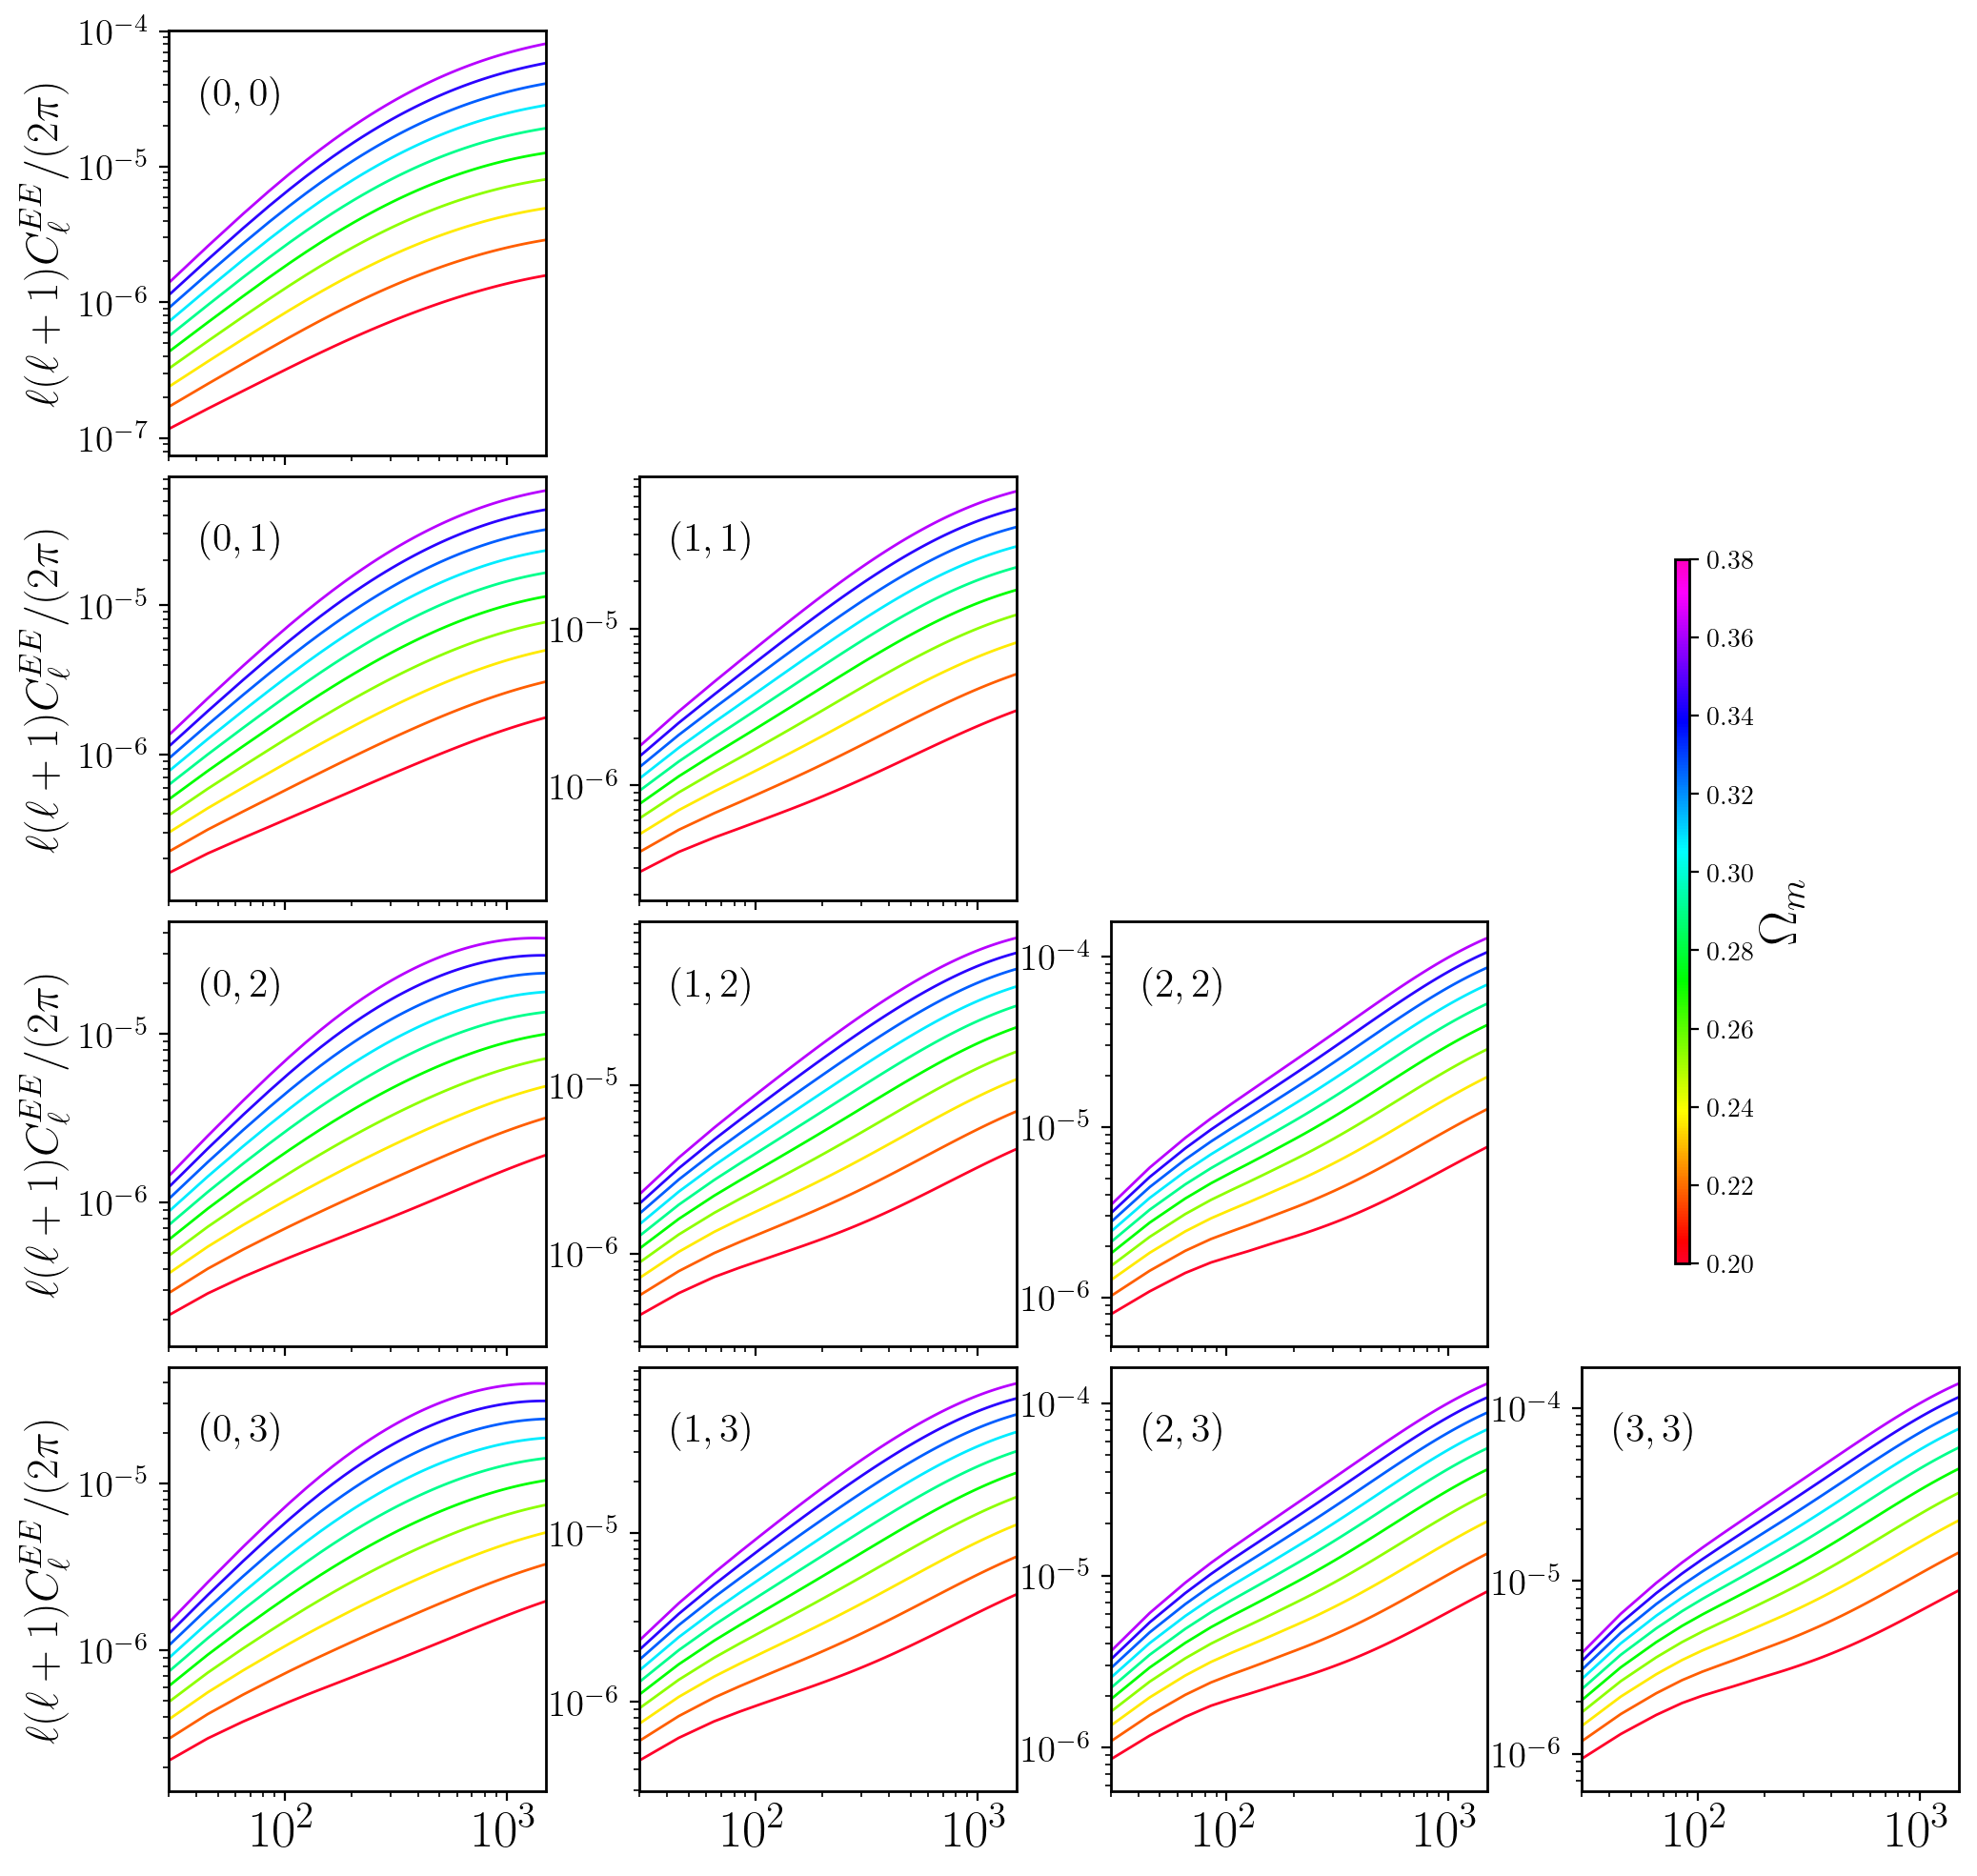

In [12]:
plot_C_ss_tomo_limber(ell=ell, C_ss=C_ss, param=param, colorbarlabel="$\Omega_m$",
                      yaxislabelsize = 17, yaxisticklabelsize = 14, xaxisticklabelsize = 20)

In [13]:
ell = np.arange(25., 1500., 20.) # Make sure arange are with float numbers (otherwise there are aliasing problems)

param = np.arange(0.85, 1.1, 0.02)

C_ss = []
for x in param:
    (Cl, tmp) = C_ss_tomo_limber(ell=ell, ns=x)
    C_ss.append(Cl)

# Plot the Ratio over ref cosmology
(ref, tmp) = C_ss_tomo_limber(ell=ell)

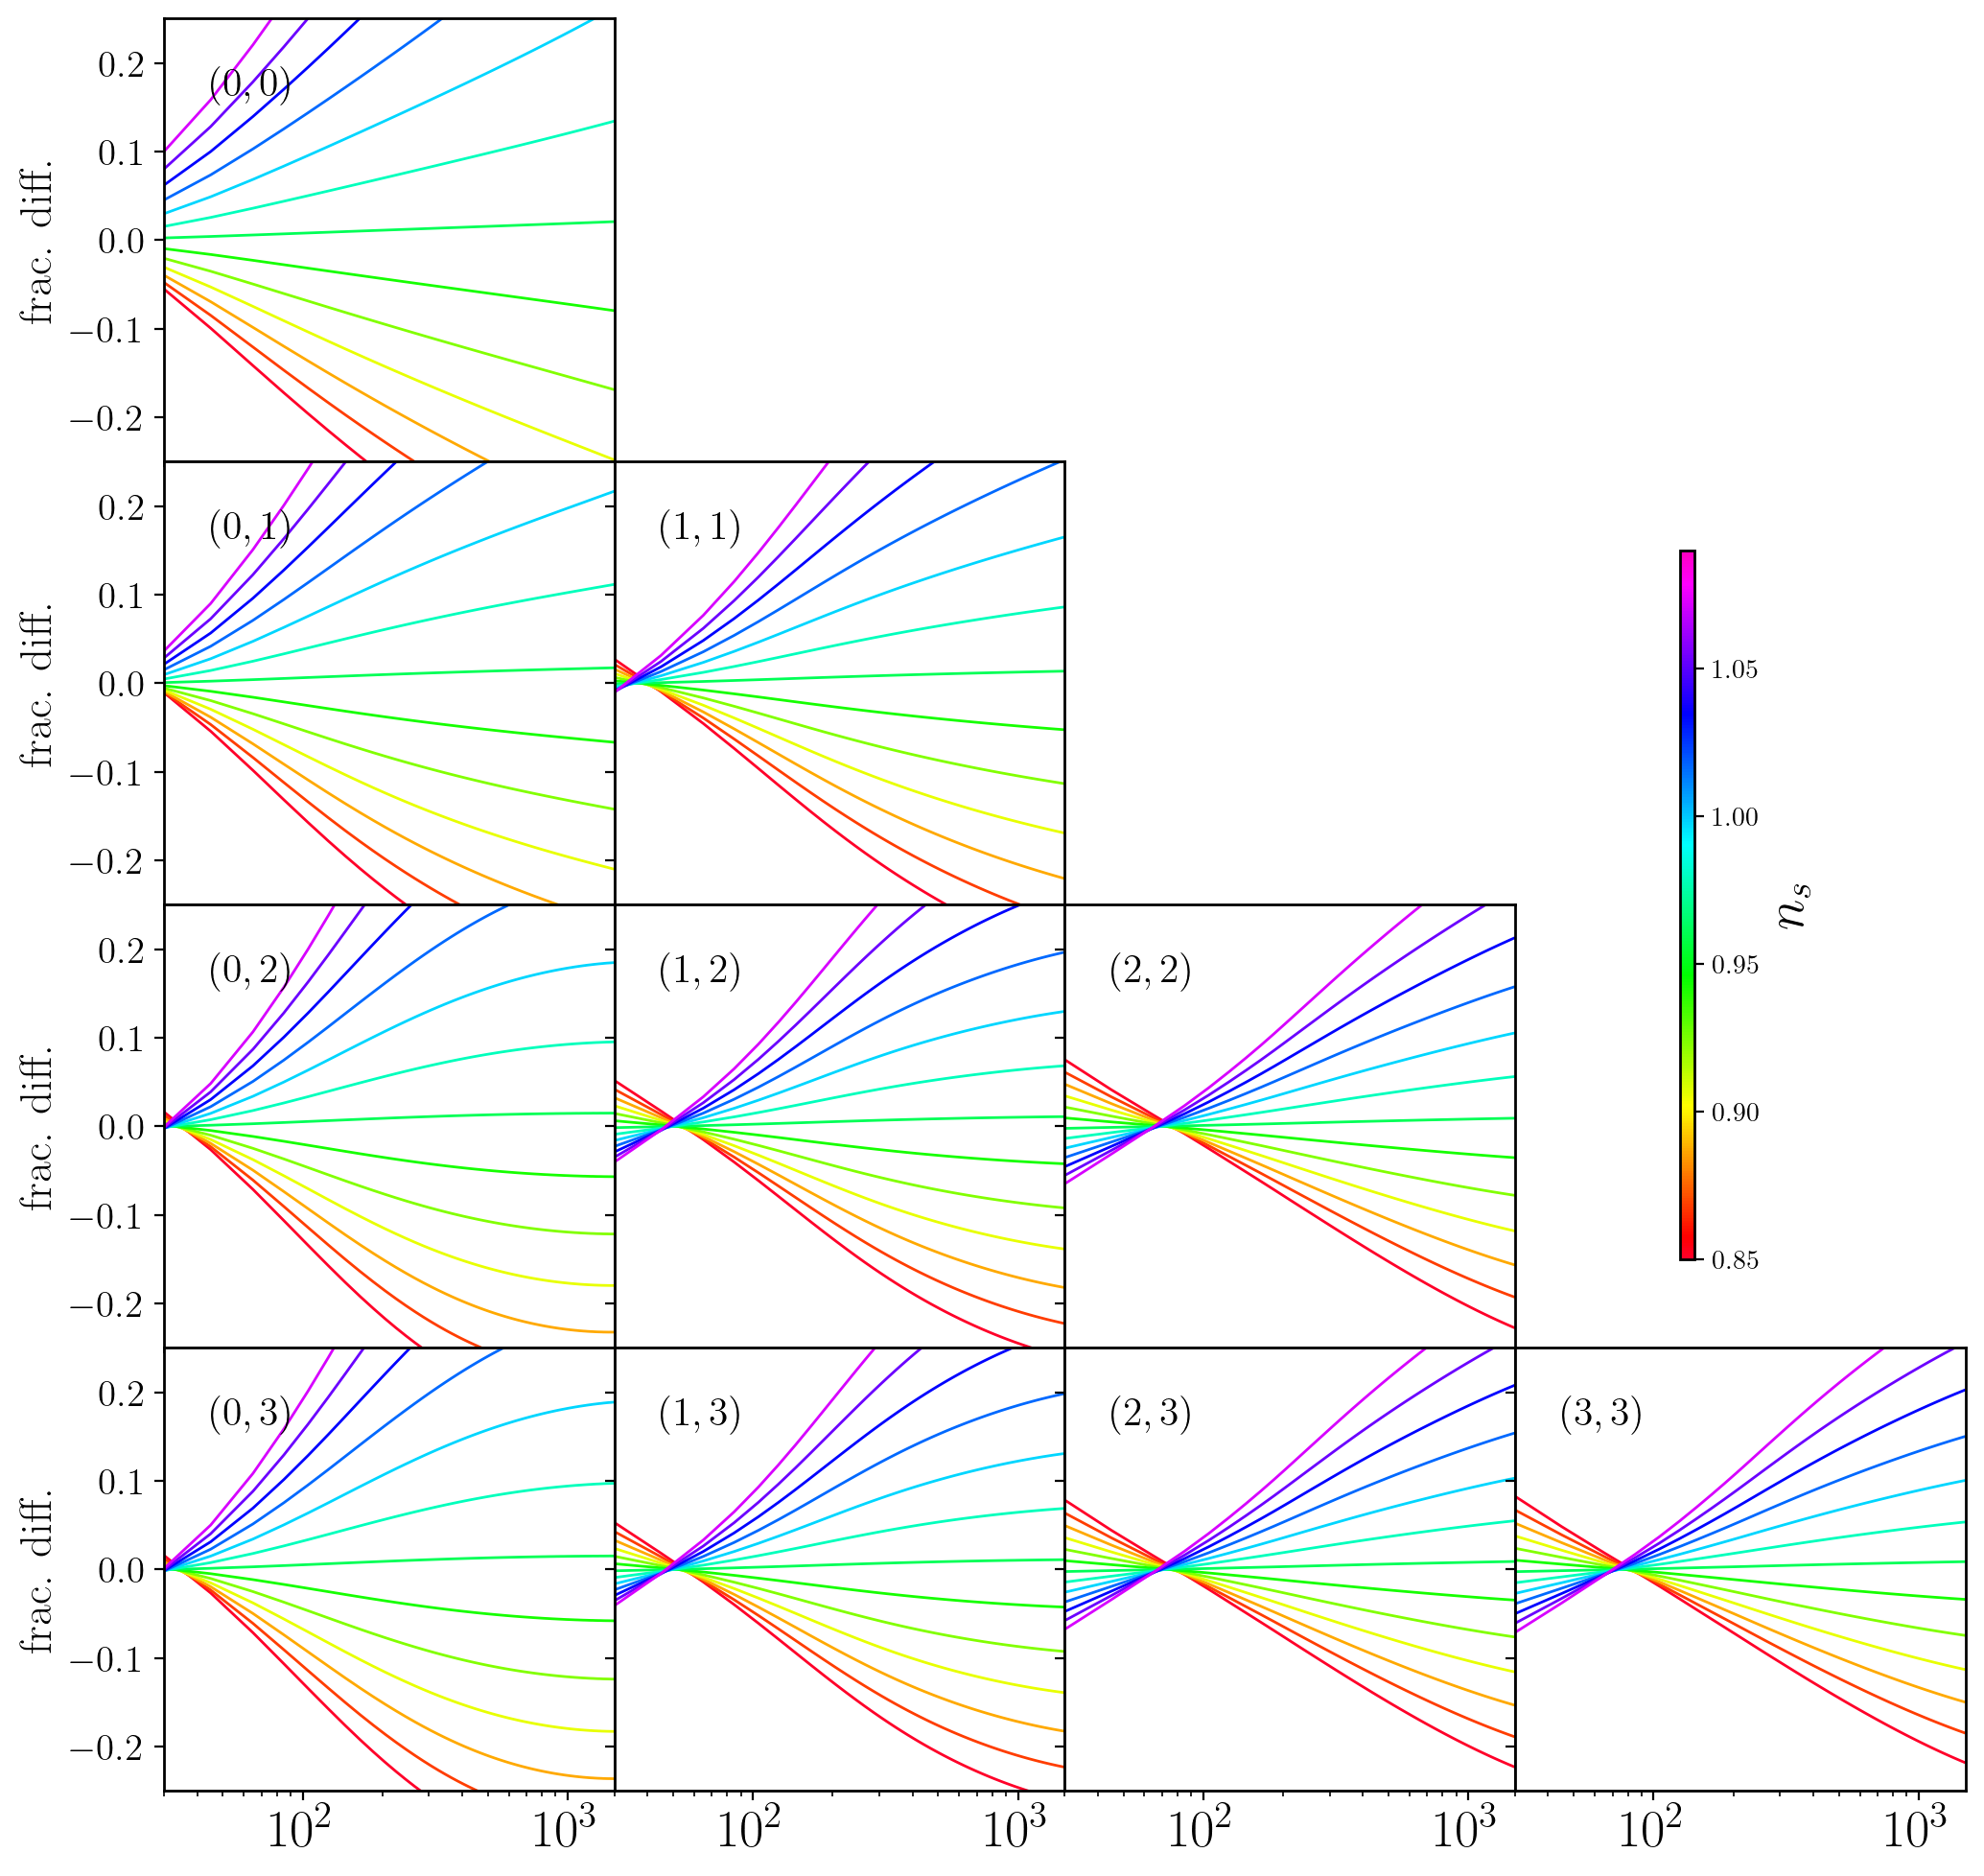

In [14]:
plot_C_ss_tomo_limber(ell=ell, C_ss=C_ss, C_ss_ref=ref, param=param, colorbarlabel="$n_s$",
                      yaxislabelsize = 17, yaxisticklabelsize = 14, xaxisticklabelsize = 20)

# Let's plot how cosmological and nuisance parameters affect $\xi(\theta)$

In [15]:
param = np.arange(0.2, 0.41, 0.02)
        
xi_theta = []
for x in param:
    xi_theta.append(xi(omegam = x))

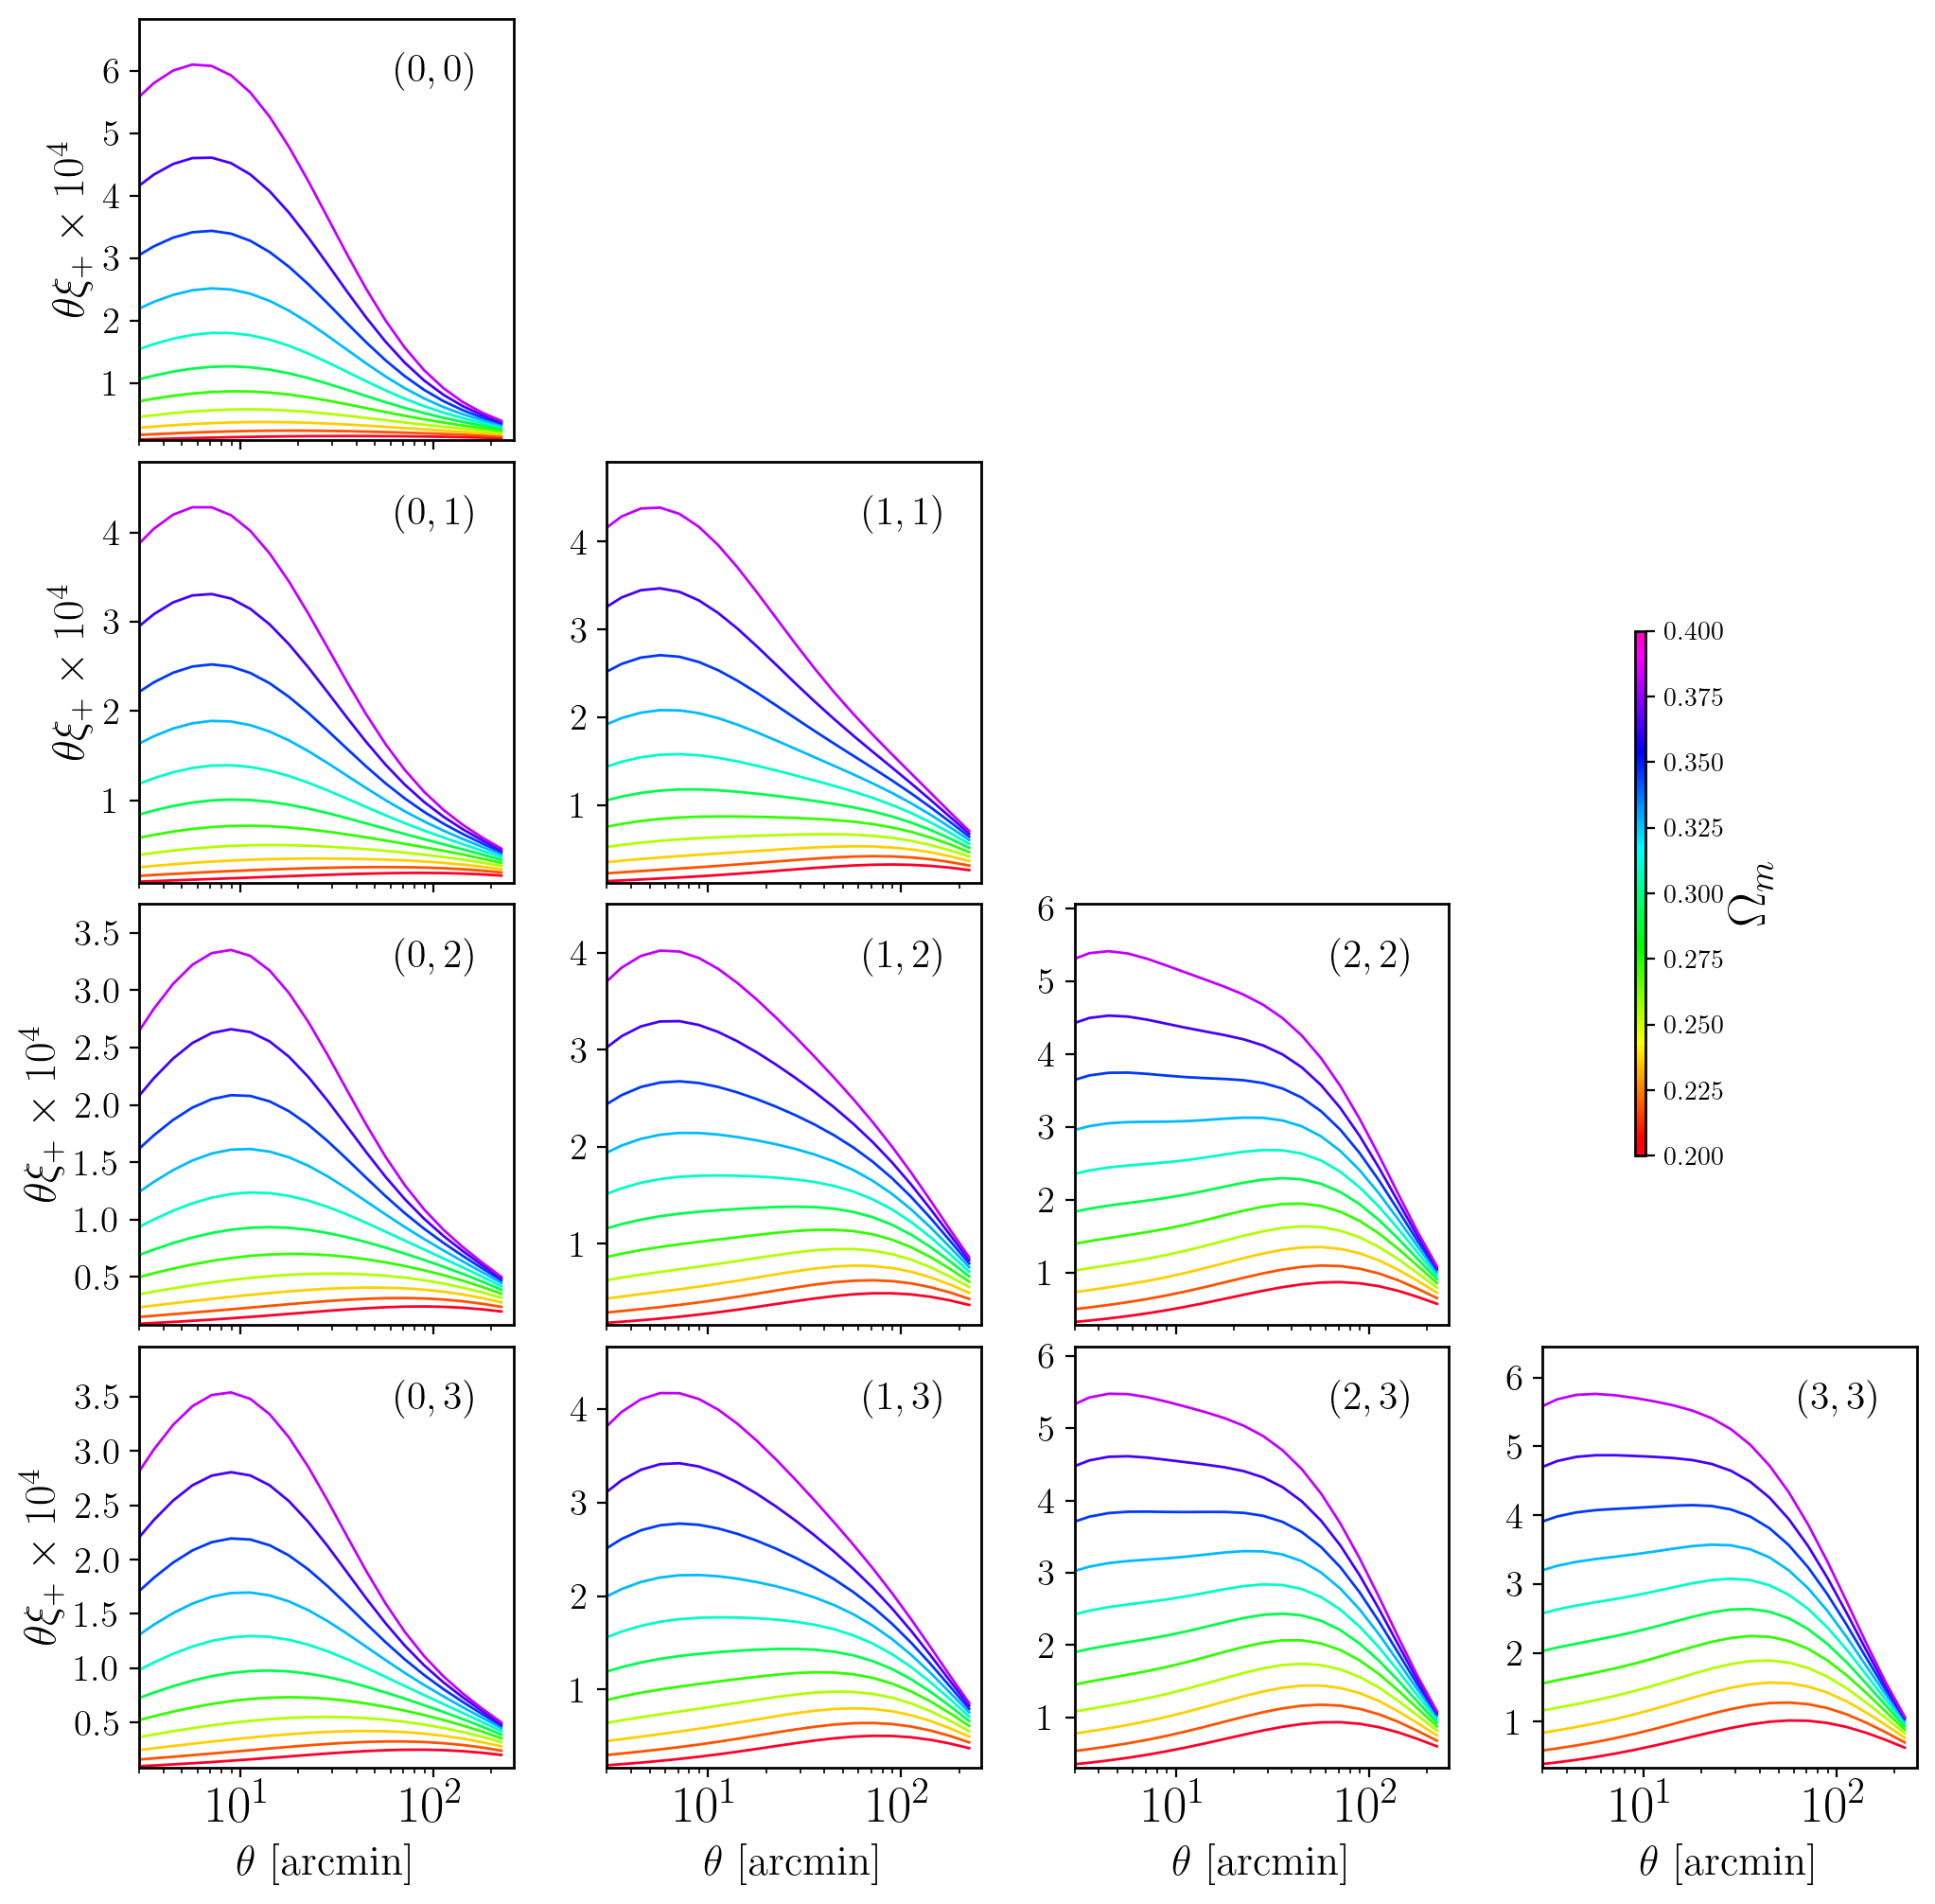

In [16]:
plot_xi(pm = 1, xi = xi_theta, param = param, colorbarlabel = "$\Omega_m$", thetashow=[3,260],
        yaxislabelsize = 17, yaxisticklabelsize = 14, xaxisticklabelsize = 20)

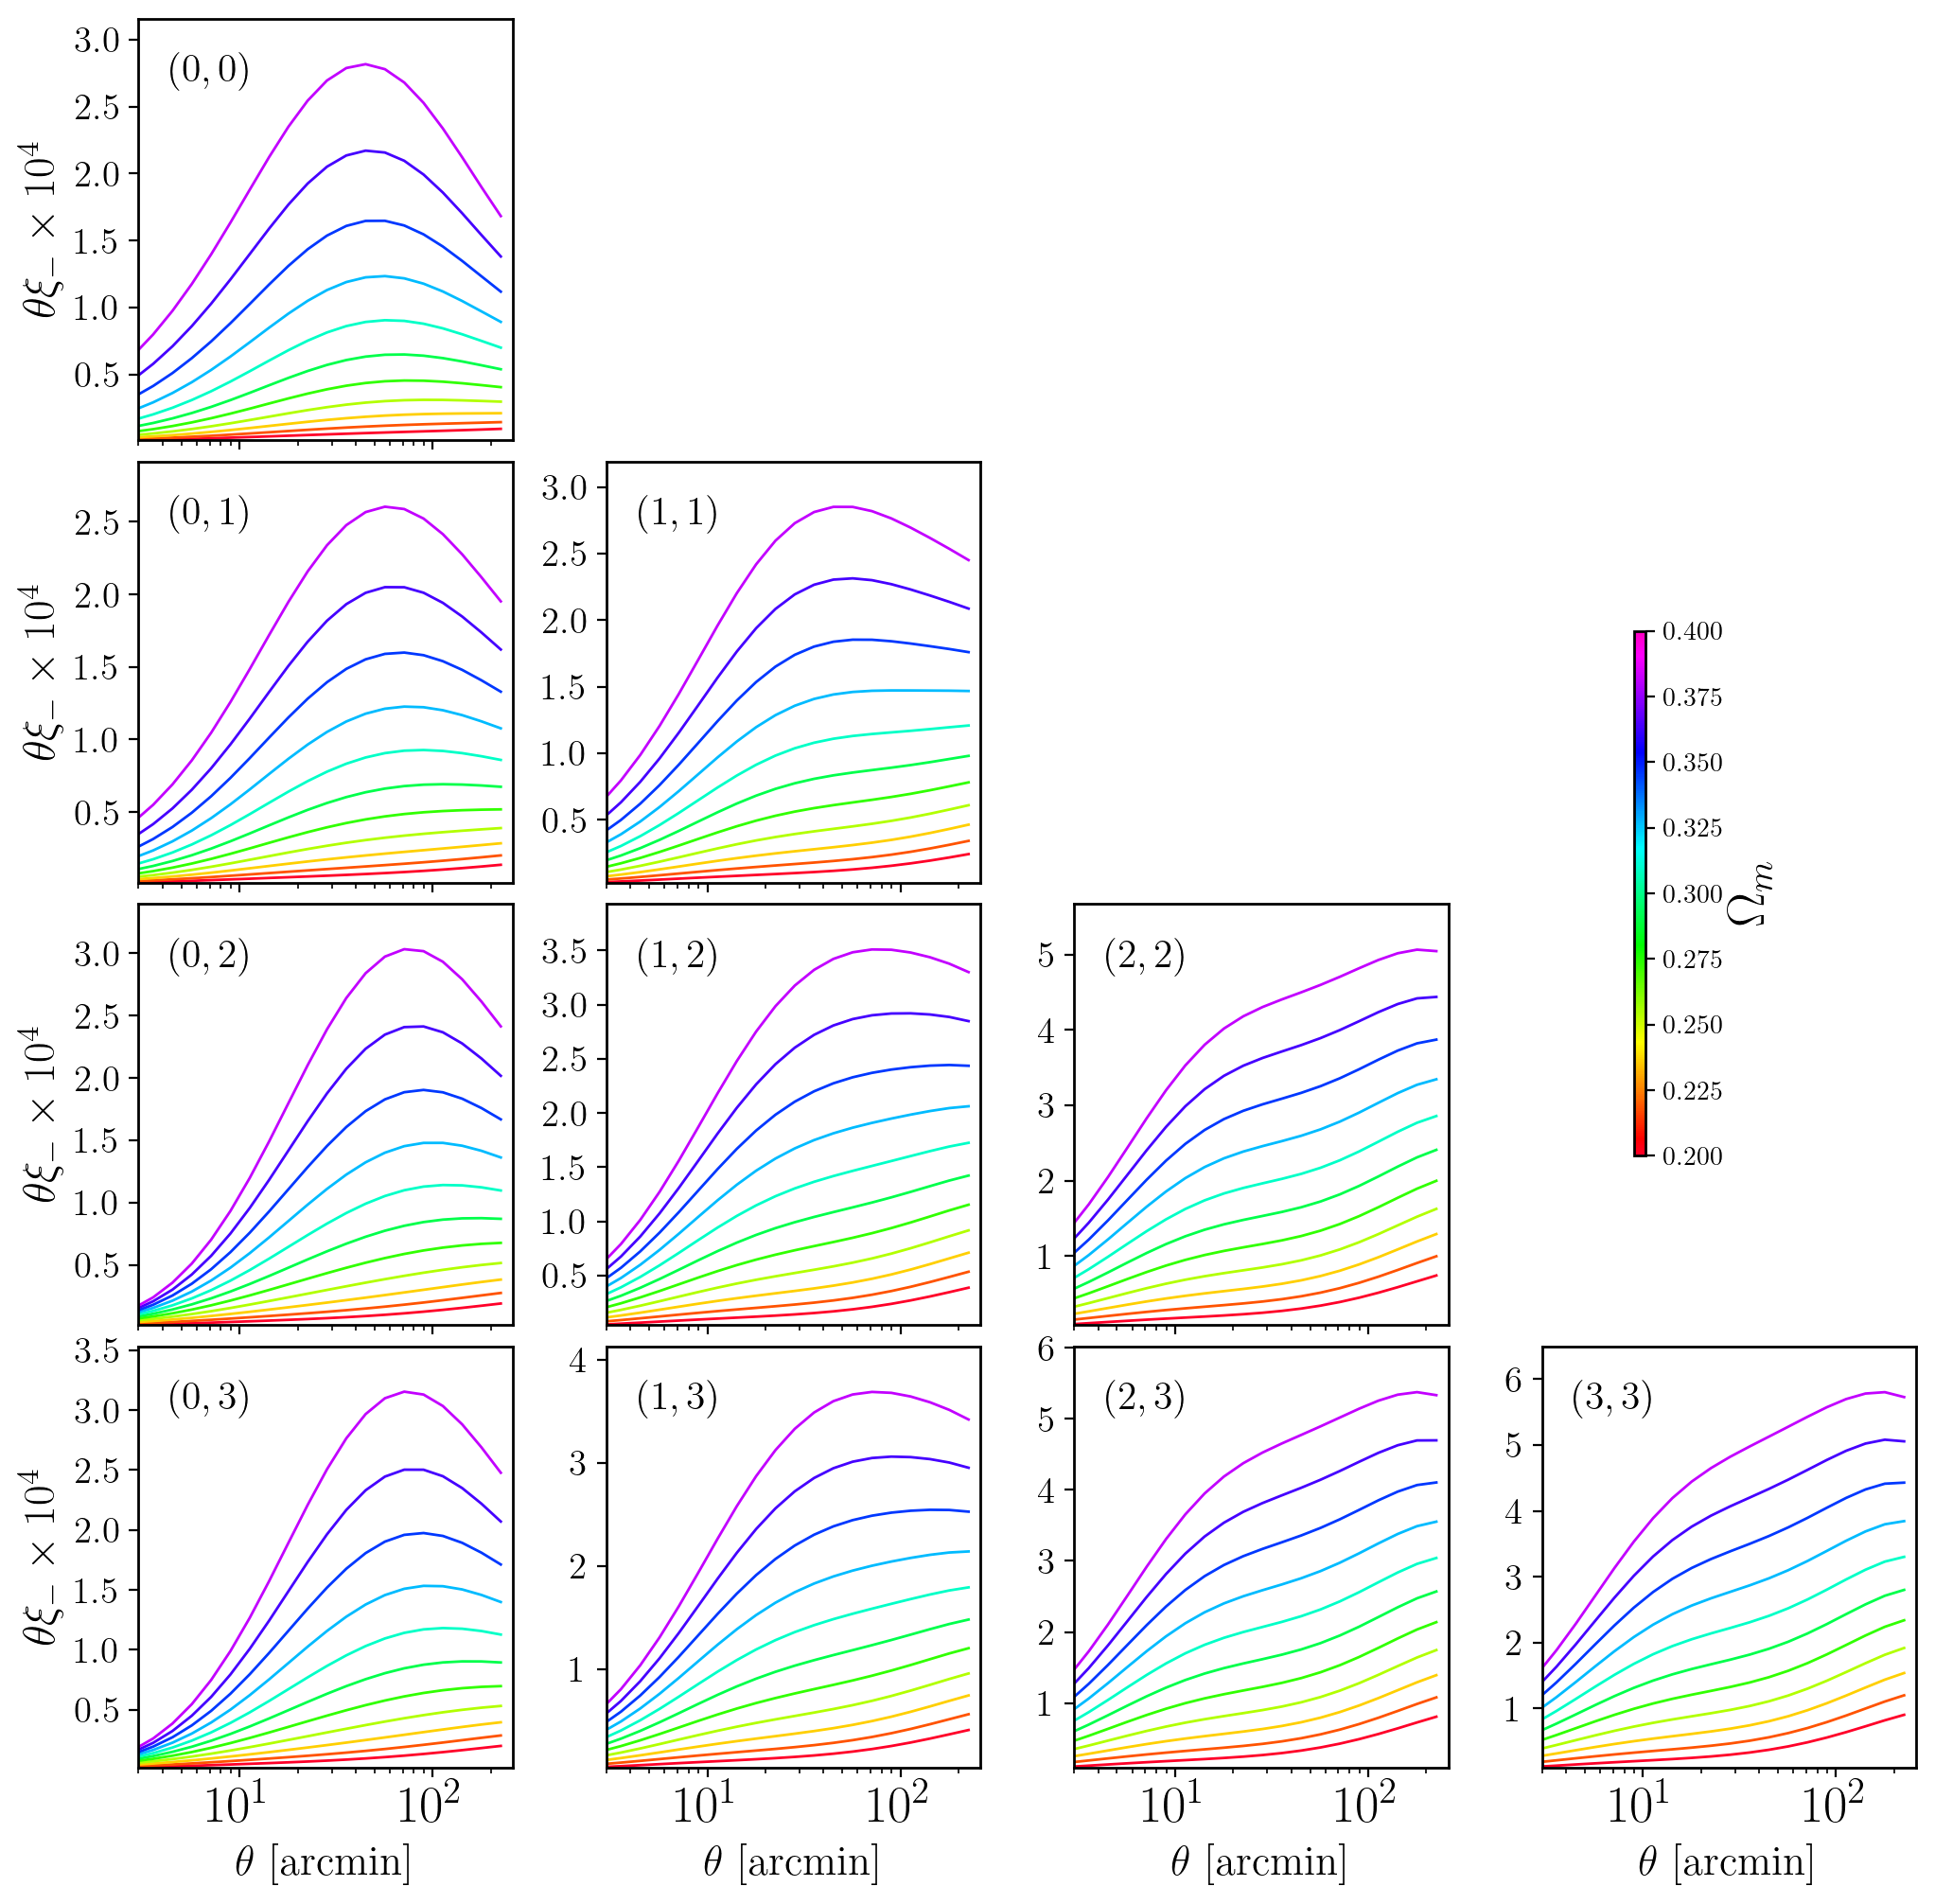

In [17]:
plot_xi(pm = -1, xi = xi_theta, param = param, colorbarlabel = "$\Omega_m$", thetashow=[3,260],
        yaxislabelsize = 17, yaxisticklabelsize = 14, xaxisticklabelsize = 20)

# Can we change the binning on $\xi(\theta)$ w/o restarting the kernel? Yes!
Why this is a nontrivial question? Because Cosmolike uses static variables to cache Glplus and Glminus

In [18]:
nthetas=[9, 12, 17, 44]

result = []
for x in nthetas:
    result.append(xi(ntheta=x))

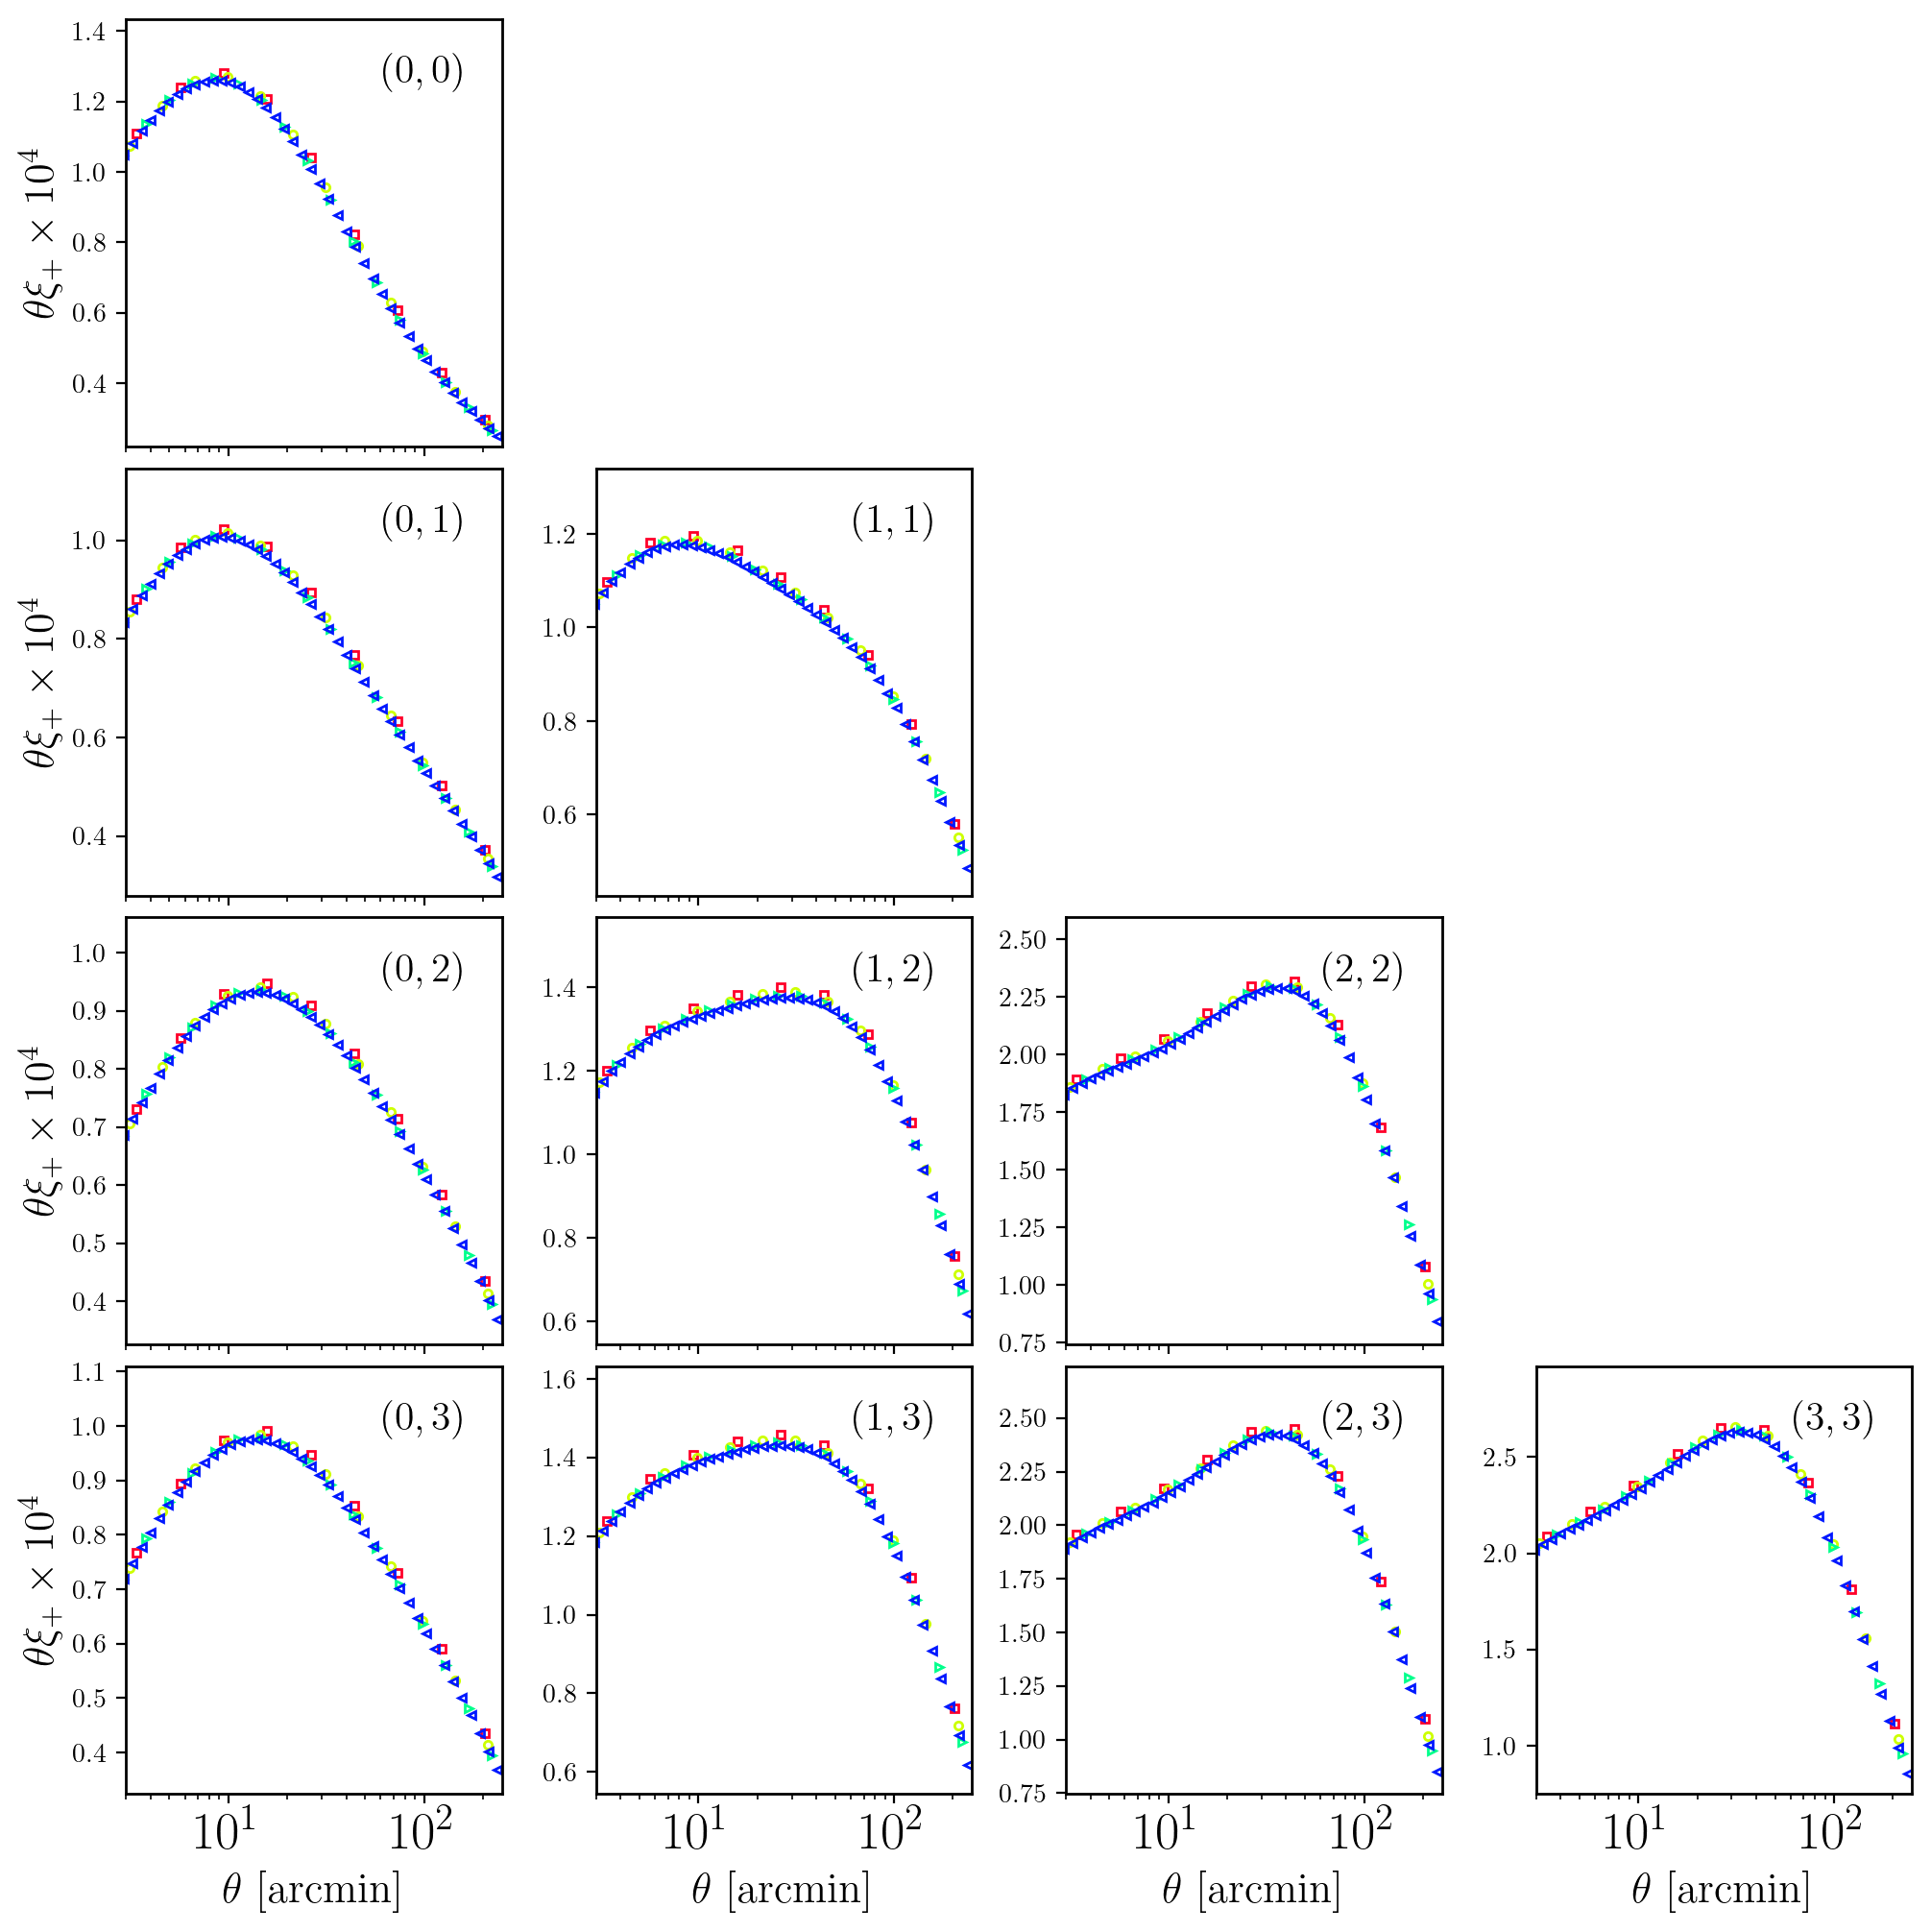

In [19]:
plot_xi(pm = 1, xi = result, marker=['s', 'o', ">", "<"])

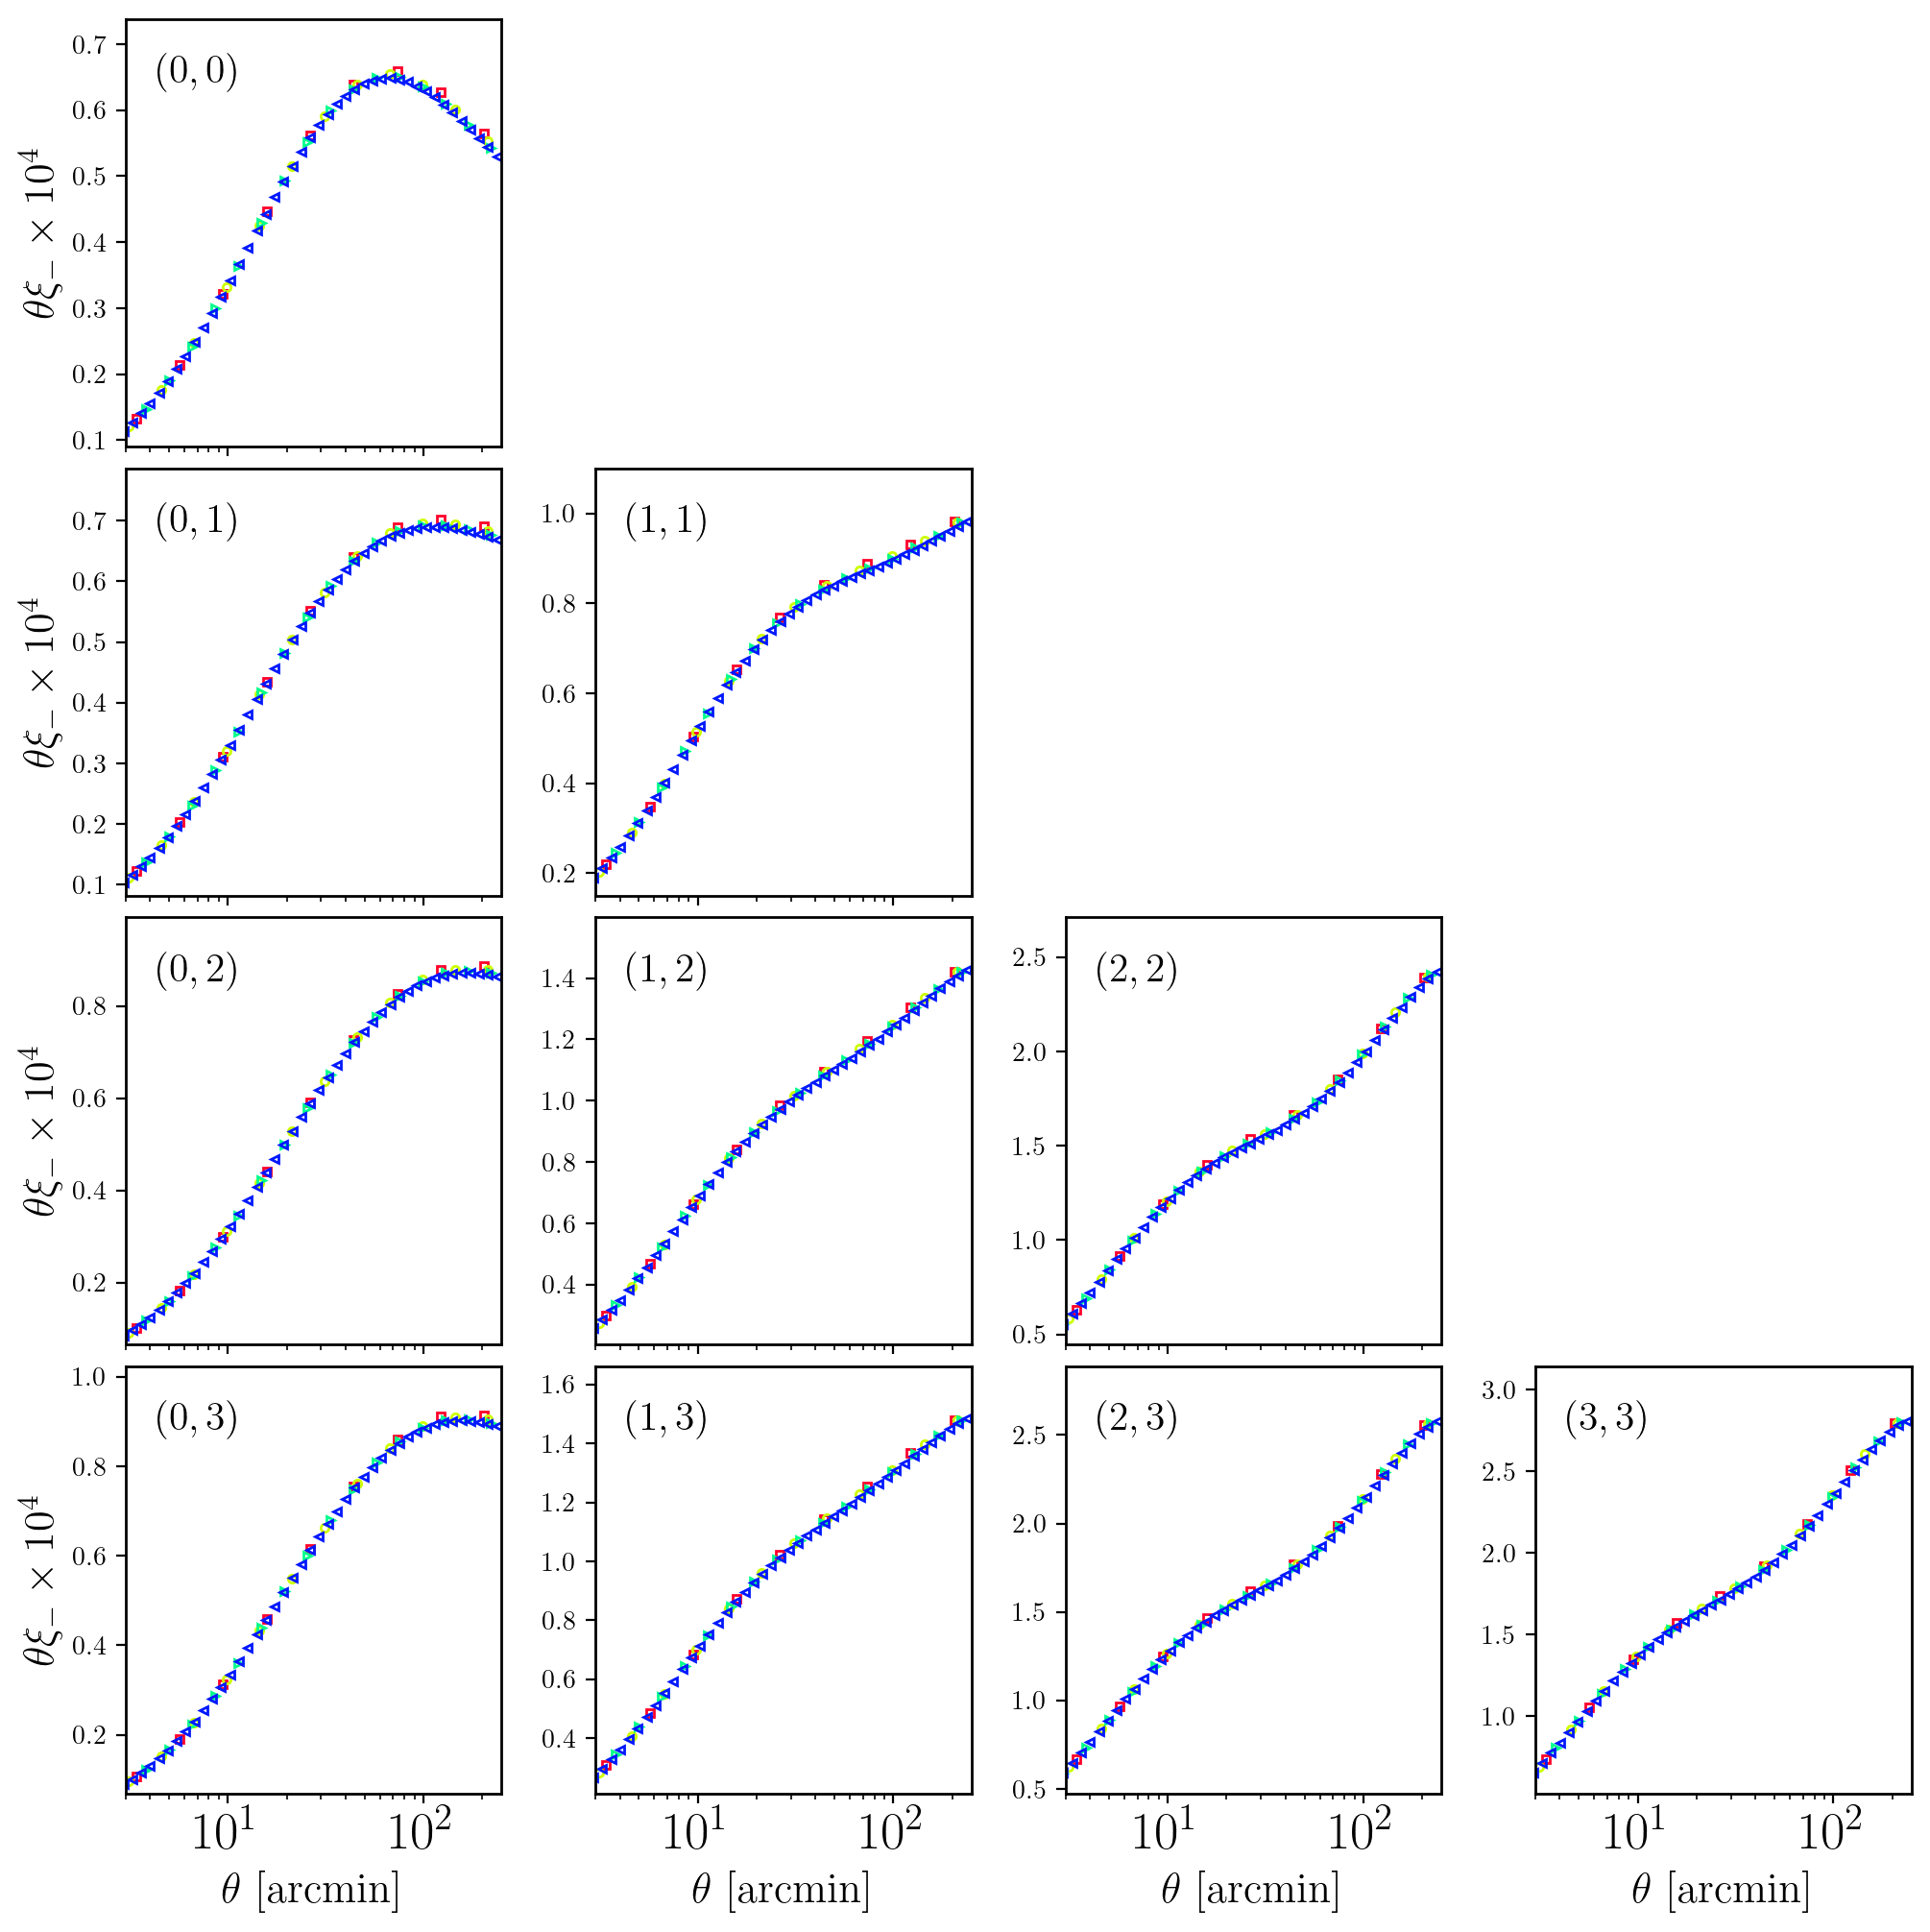

In [20]:
plot_xi(pm = -1, xi = result, marker=['s', 'o', ">", "<"])

# Add Baryon Contamination to $C_\ell^{\rm EE}$ and $\xi(\theta)$ data vectors

In [21]:
ell = np.arange(3., 7500., 10.) # Make sure np.arange are set w/ float numbers (otherwise there are aliasing problems)
param = ("TNG100-1", "HzAGN-1", "mb2-1", "illustris-1", "eagle-1", "owls_AGN-1", "owls_AGN-2", "owls_AGN-3", "BAHAMAS-2")
        
C_ss = []
for x in param:
    (Cl, tmp) = C_ss_tomo_limber(ell=ell, baryon_sims=x)
    C_ss.append(Cl)
    
# Plot the Ratio over ref cosmology
(C_ss_ref, tmp) = C_ss_tomo_limber(ell=ell)

xi_theta = []
for x in param:
    xi_theta.append(xi(baryon_sims=x, ntheta=40, AccuracyBoost=1.0))

xi_theta_ref = xi(ntheta=40, AccuracyBoost=1.0)

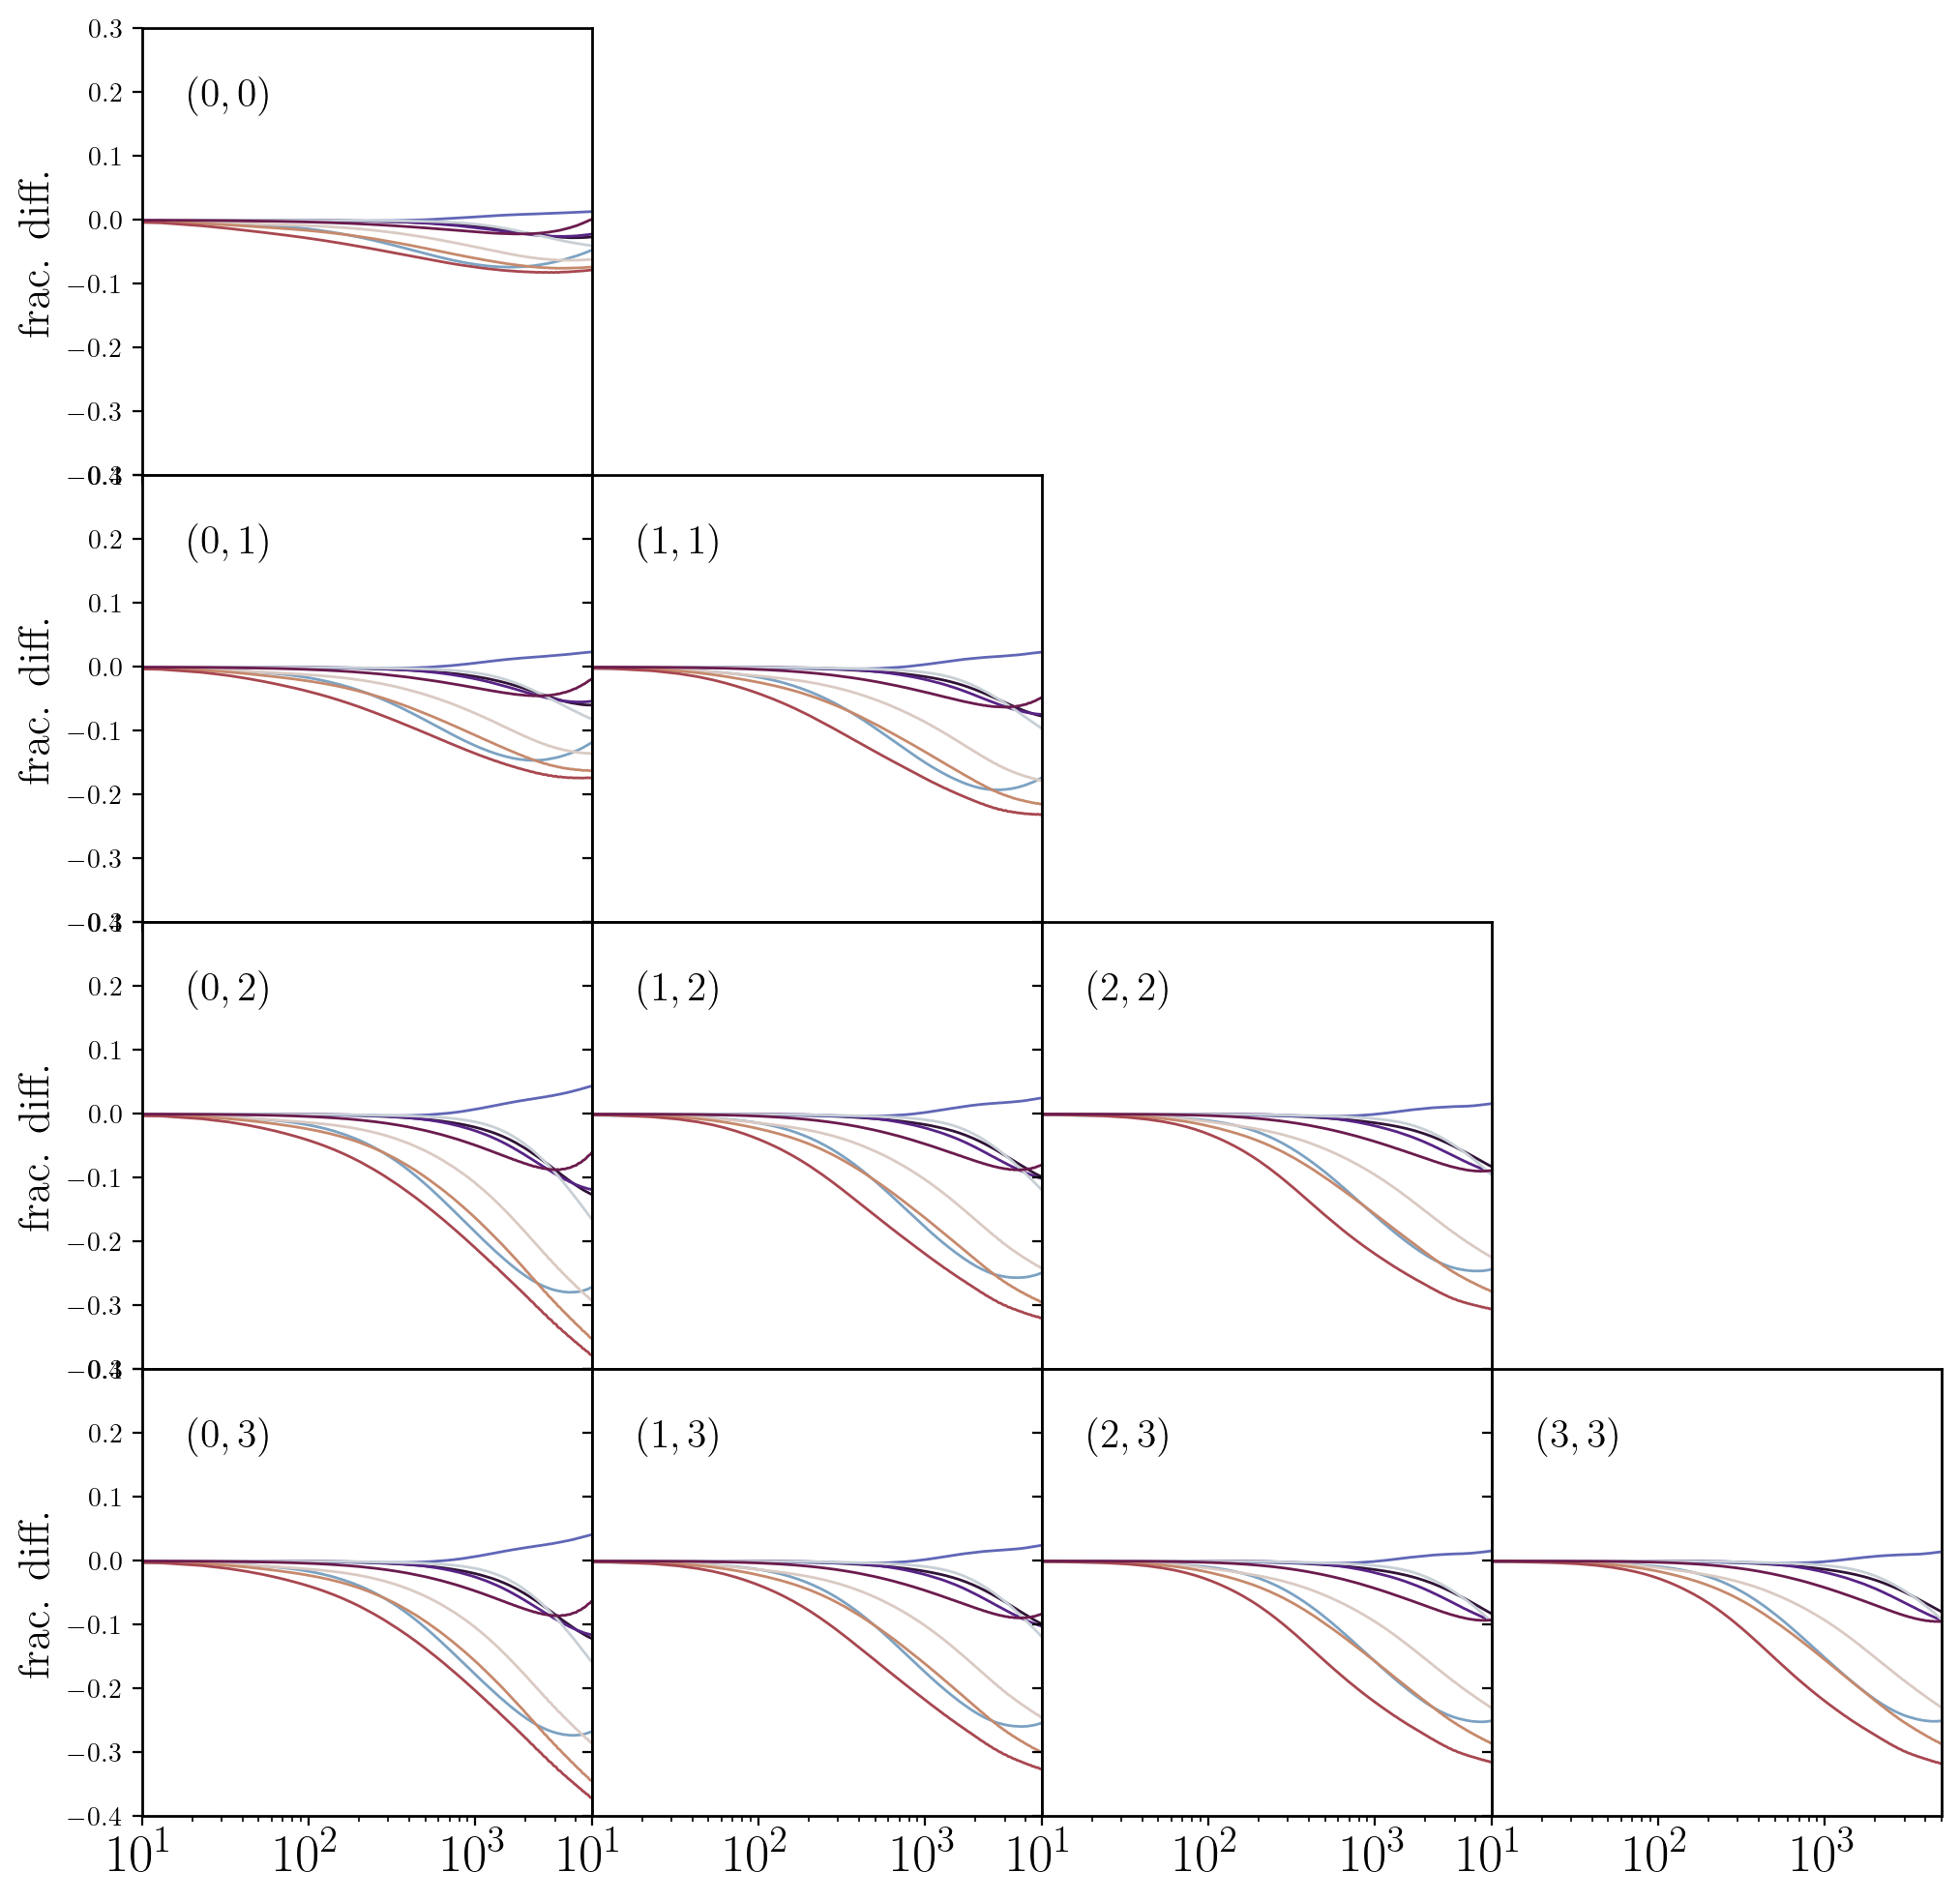

In [22]:
plot_C_ss_tomo_limber(ell=ell, C_ss=C_ss,  C_ss_ref=C_ss_ref, lmin=10, lmax=5000, cmap="twilight_shifted", ylim=(0.6,1.3))

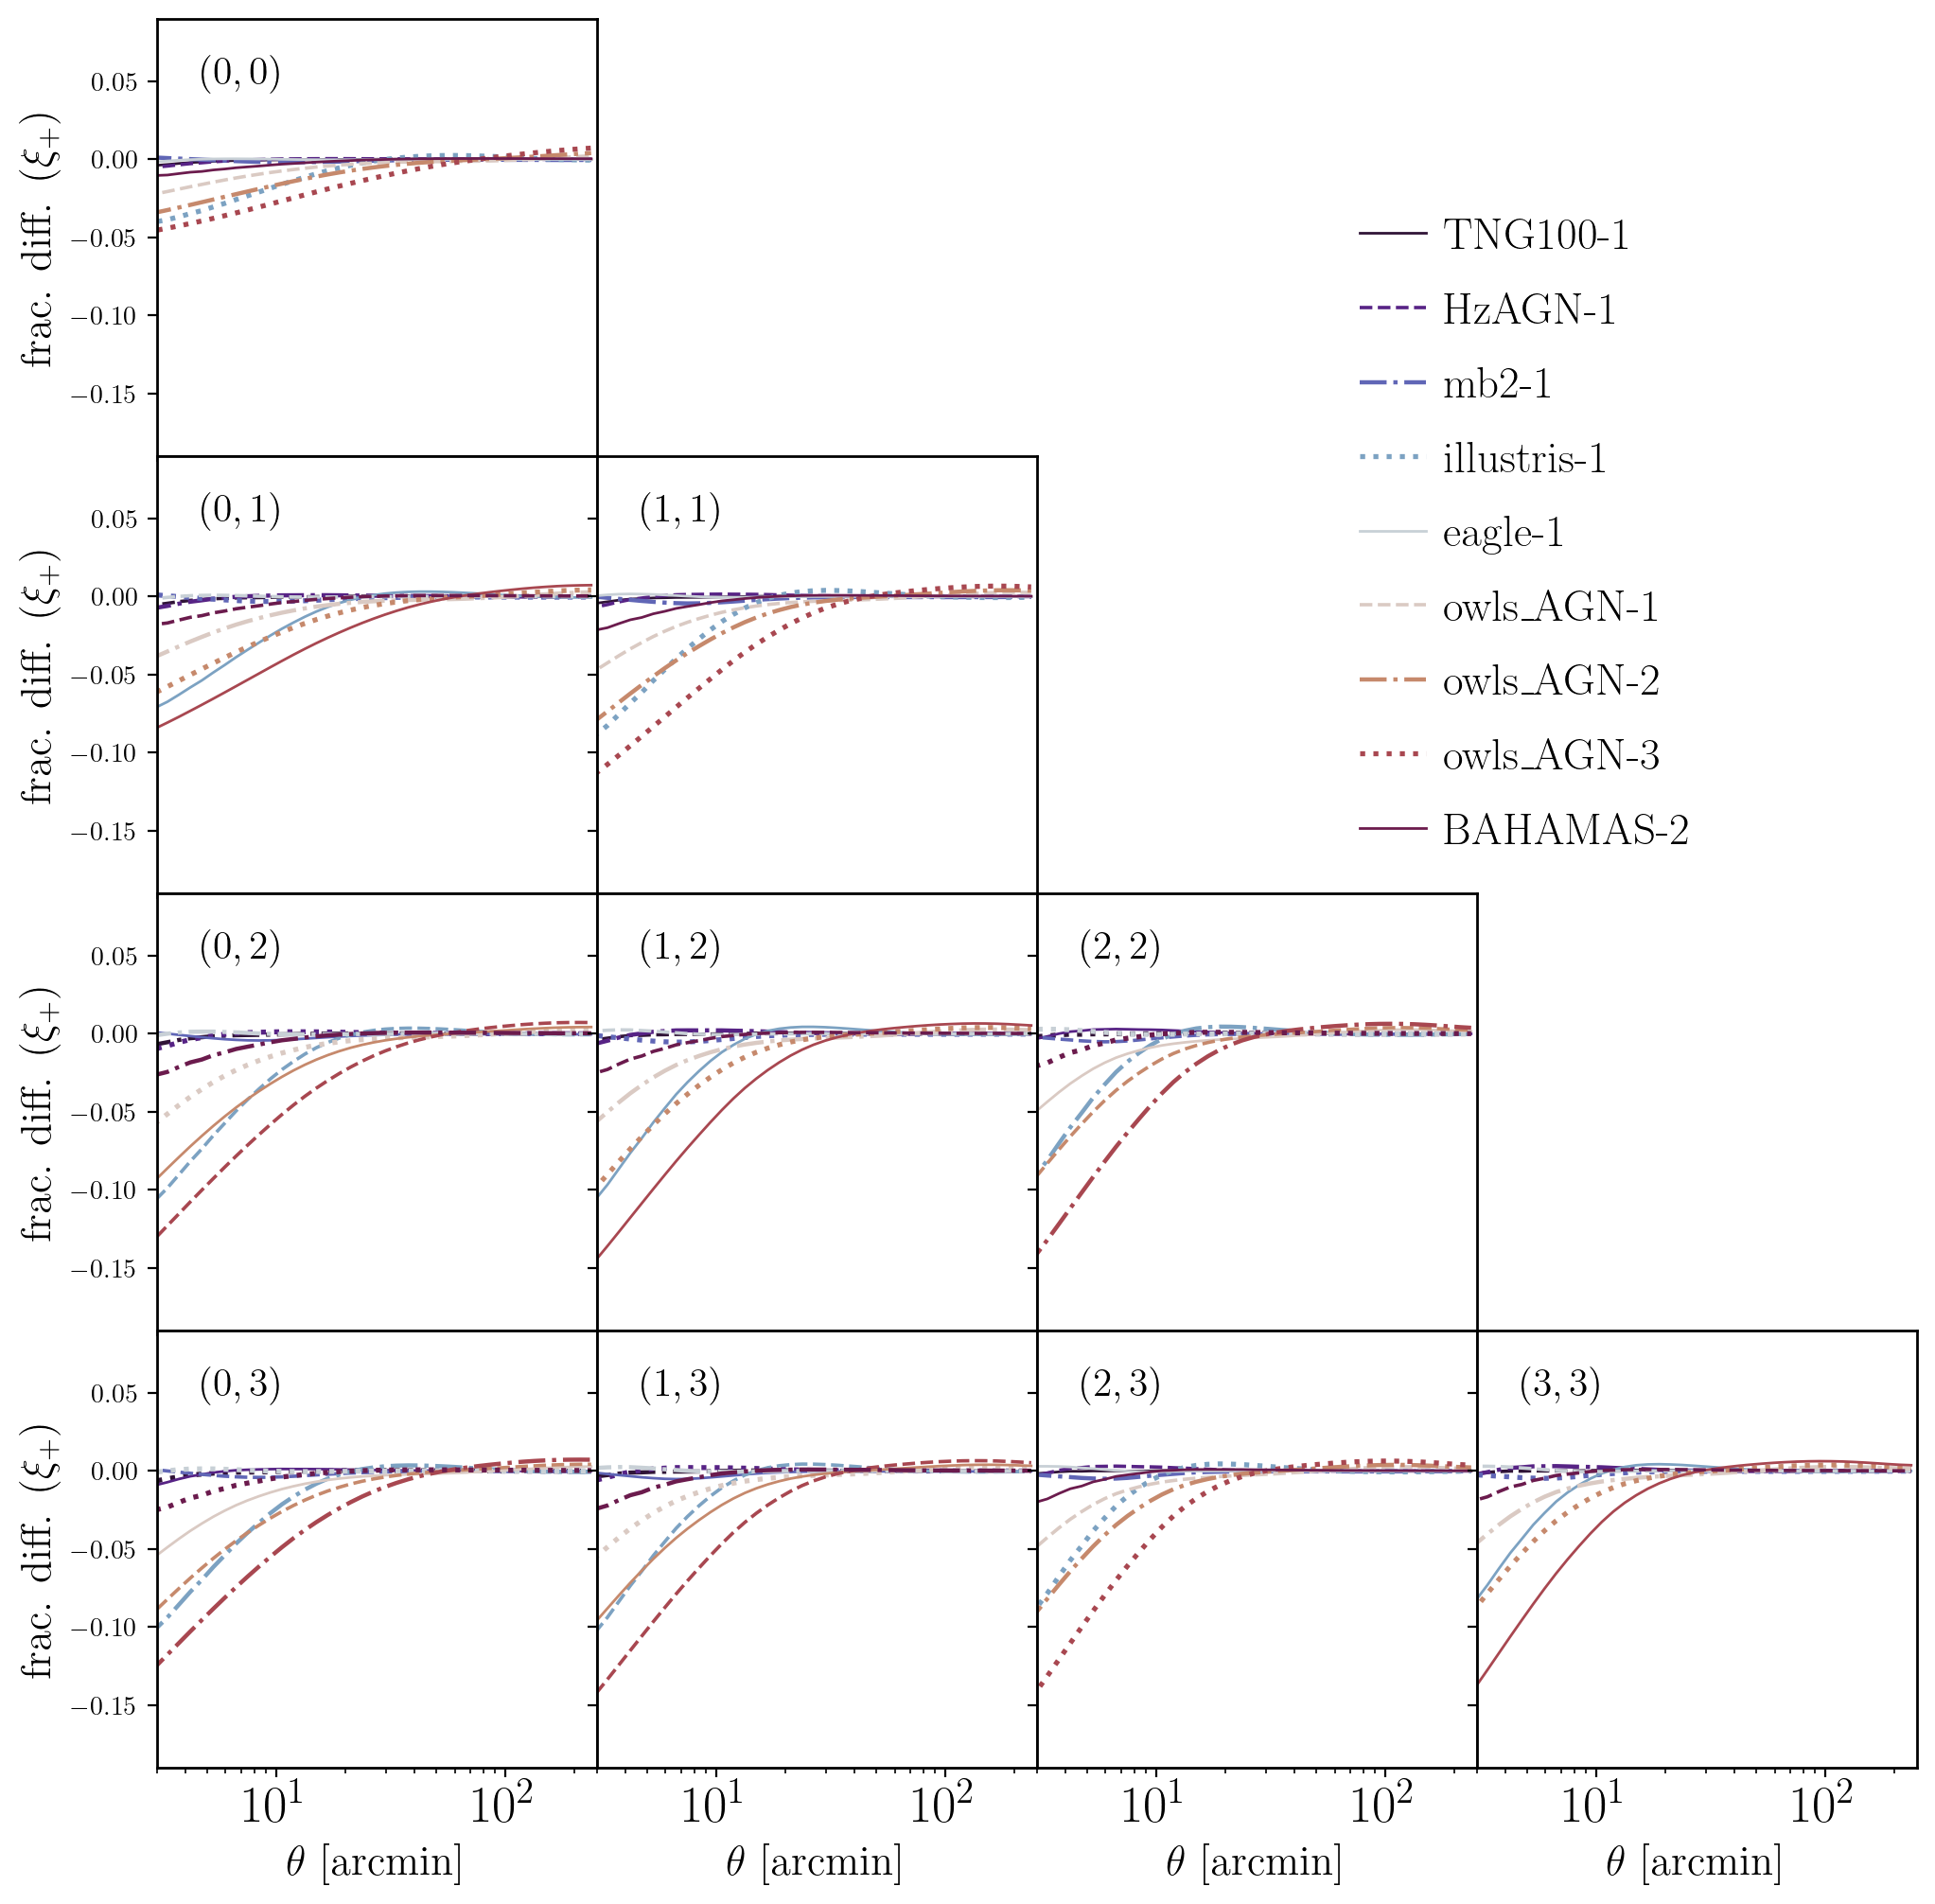

In [23]:
matplotlib.rcParams['legend.fontsize'] = 17
 
plot_xi(pm = 1, param=None, xi=xi_theta,  xi_ref=xi_theta_ref, cmap="twilight_shifted", 
            ylim=(0.81,1.09), linewidth=[1.0, 1.3, 1.6, 1.9], 
            linestyle = ['solid', 'dashed', 'dashdot', 'dotted'],
            legend = param, legendloc=(0.7,0.55), bintextpos = [[0.2, 0.875],[0.2,0.875]])

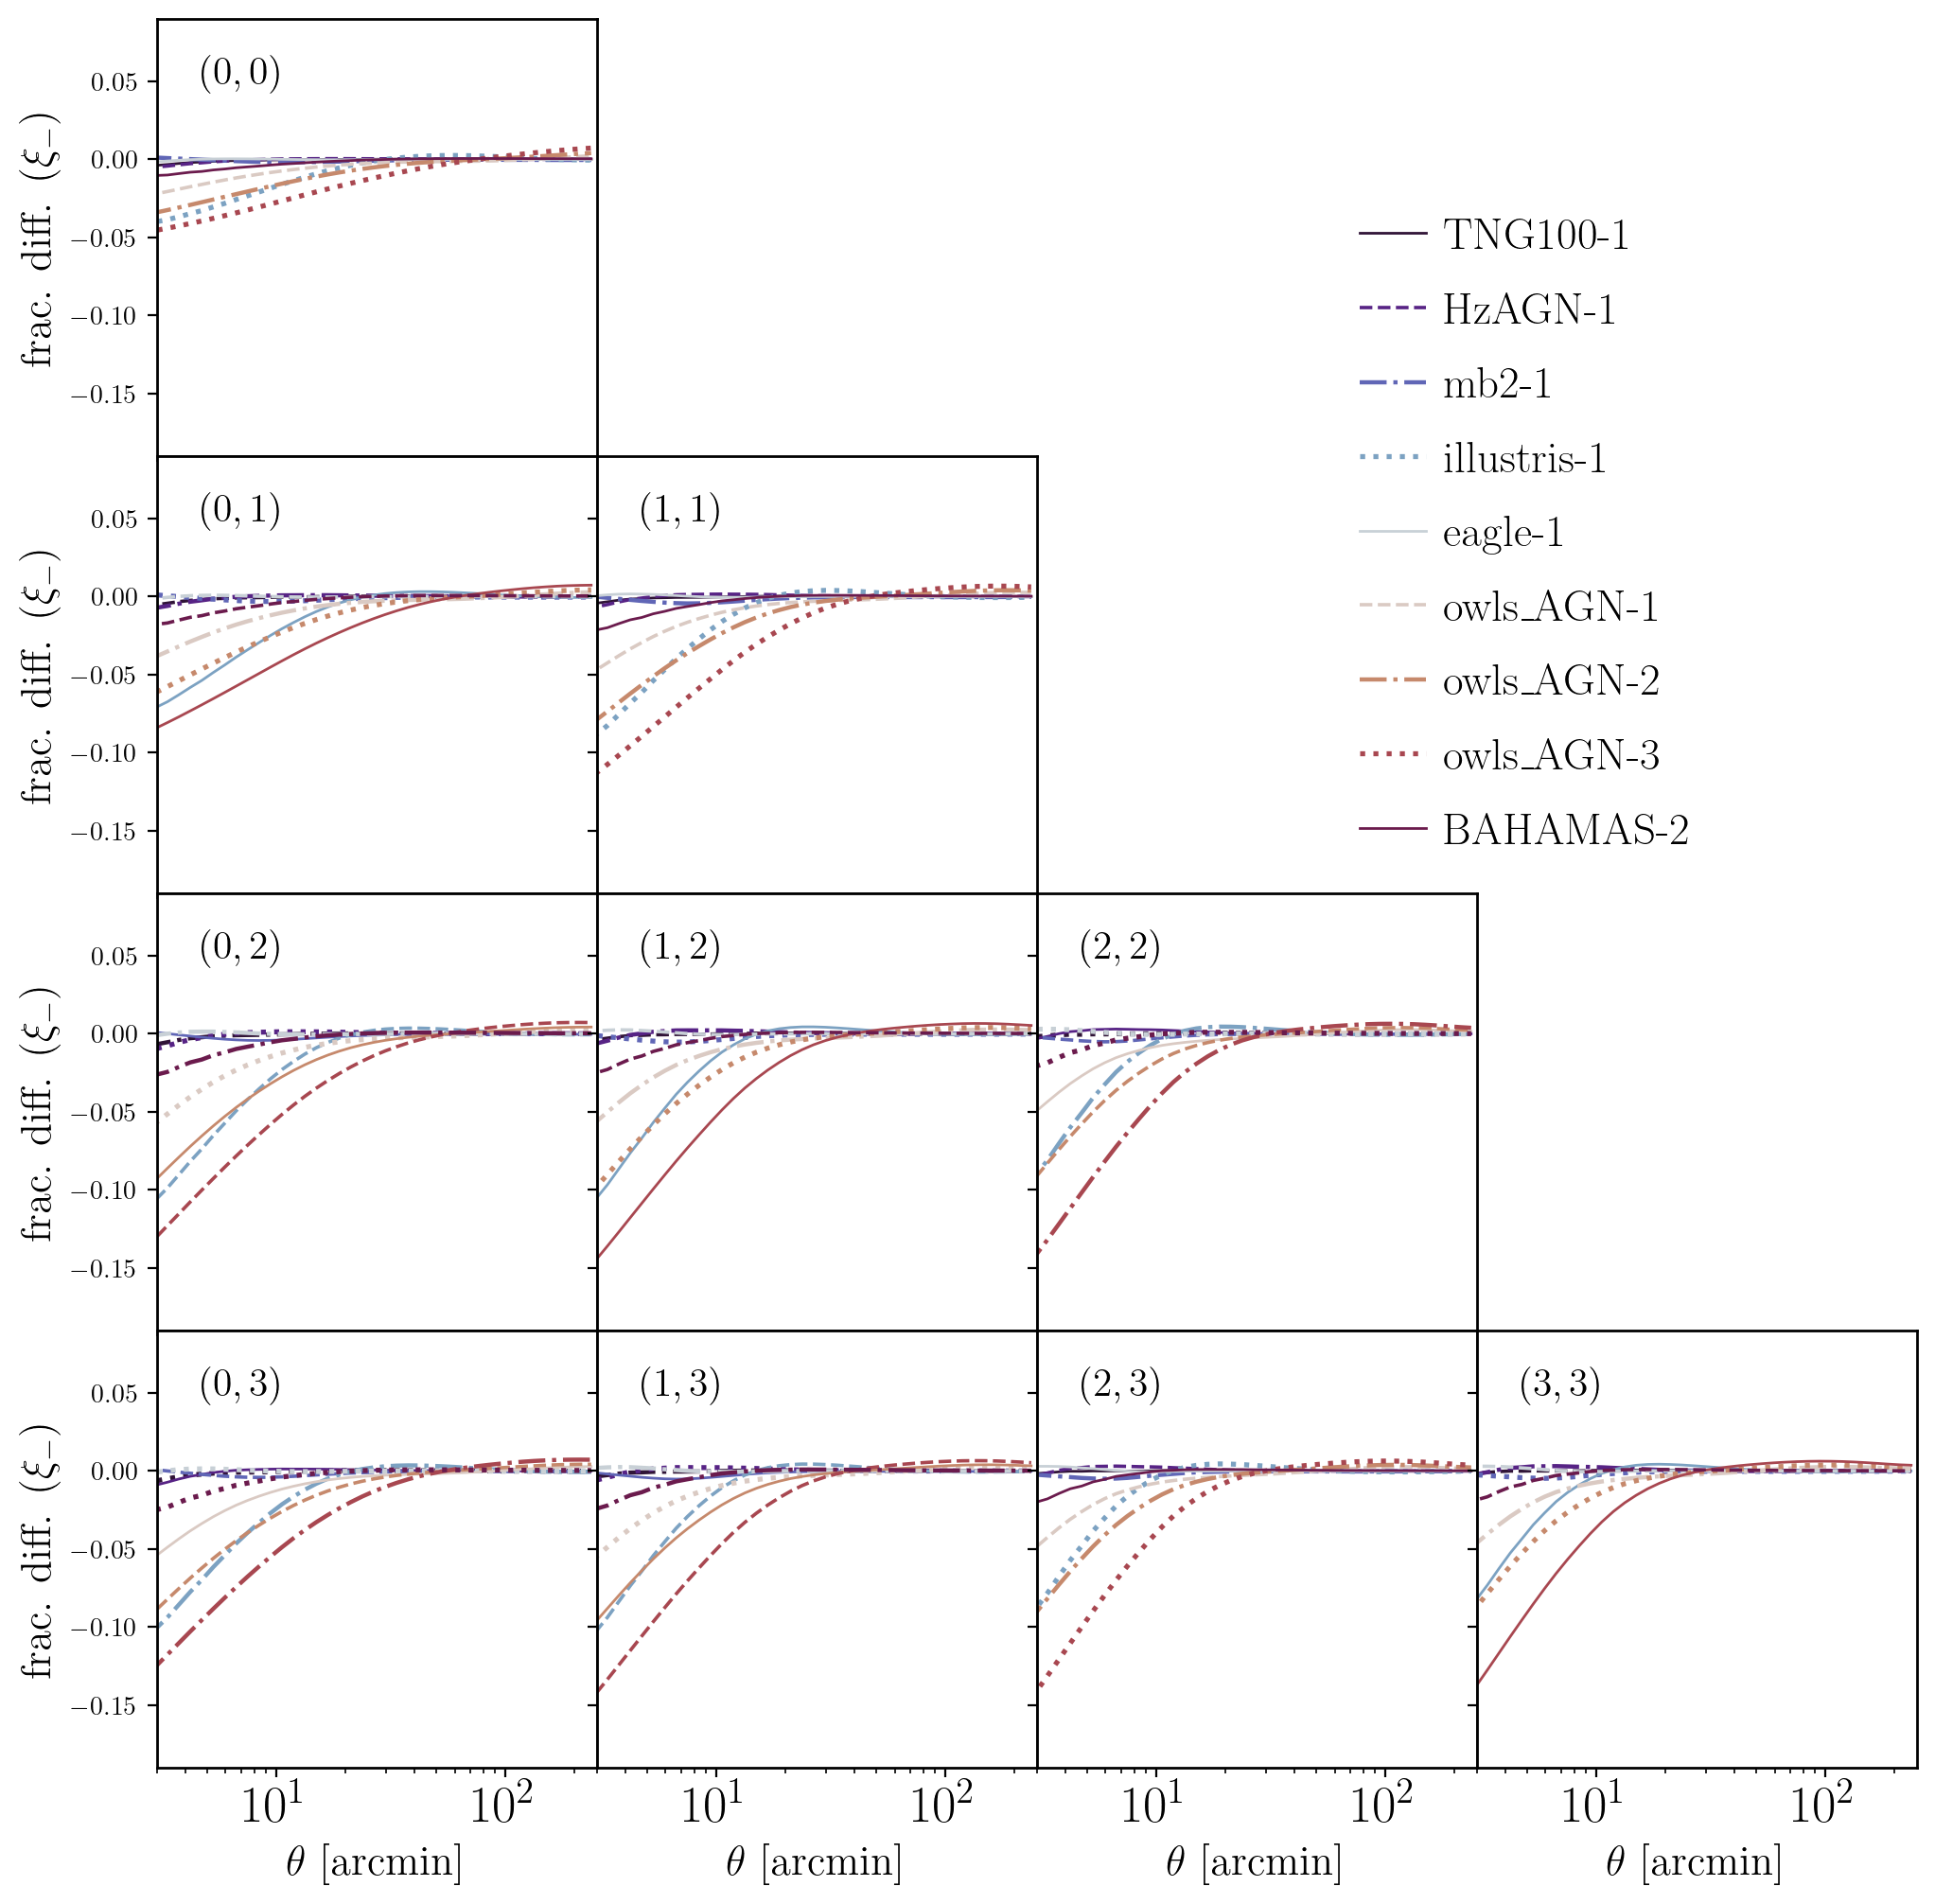

In [24]:
plot_xi(pm = -1, param=None, xi=xi_theta,  xi_ref=xi_theta_ref, cmap="twilight_shifted", 
            ylim=(0.81,1.09), linewidth=[1.0, 1.3, 1.6, 1.9], 
            linestyle = ['solid', 'dashed', 'dashdot', 'dotted'],
            legend = param, legendloc=(0.7,0.55), bintextpos = [[0.2, 0.875],[0.2,0.875]])

# Check how CAMB and Cosmolike Accuracy Boost affect $C_\ell^{\rm EE}$ and $w(\theta)$ data vectors (and $\chi^2)$

In [25]:
ell = np.arange(10., 8500., 30.) # Make sure np.arange are set w/ float numbers (otherwise there are aliasing problems)

param = np.arange(0.45, 2.0, 0.25)
        
C_ss = []
for x in param:
    (Cl, tmp) = C_ss_tomo_limber(ell=ell, AccuracyBoost=x)
    C_ss.append(Cl)

# Plot the Ratio over ref cosmology
(C_ss_ref, tmp) = C_ss_tomo_limber(ell=ell)

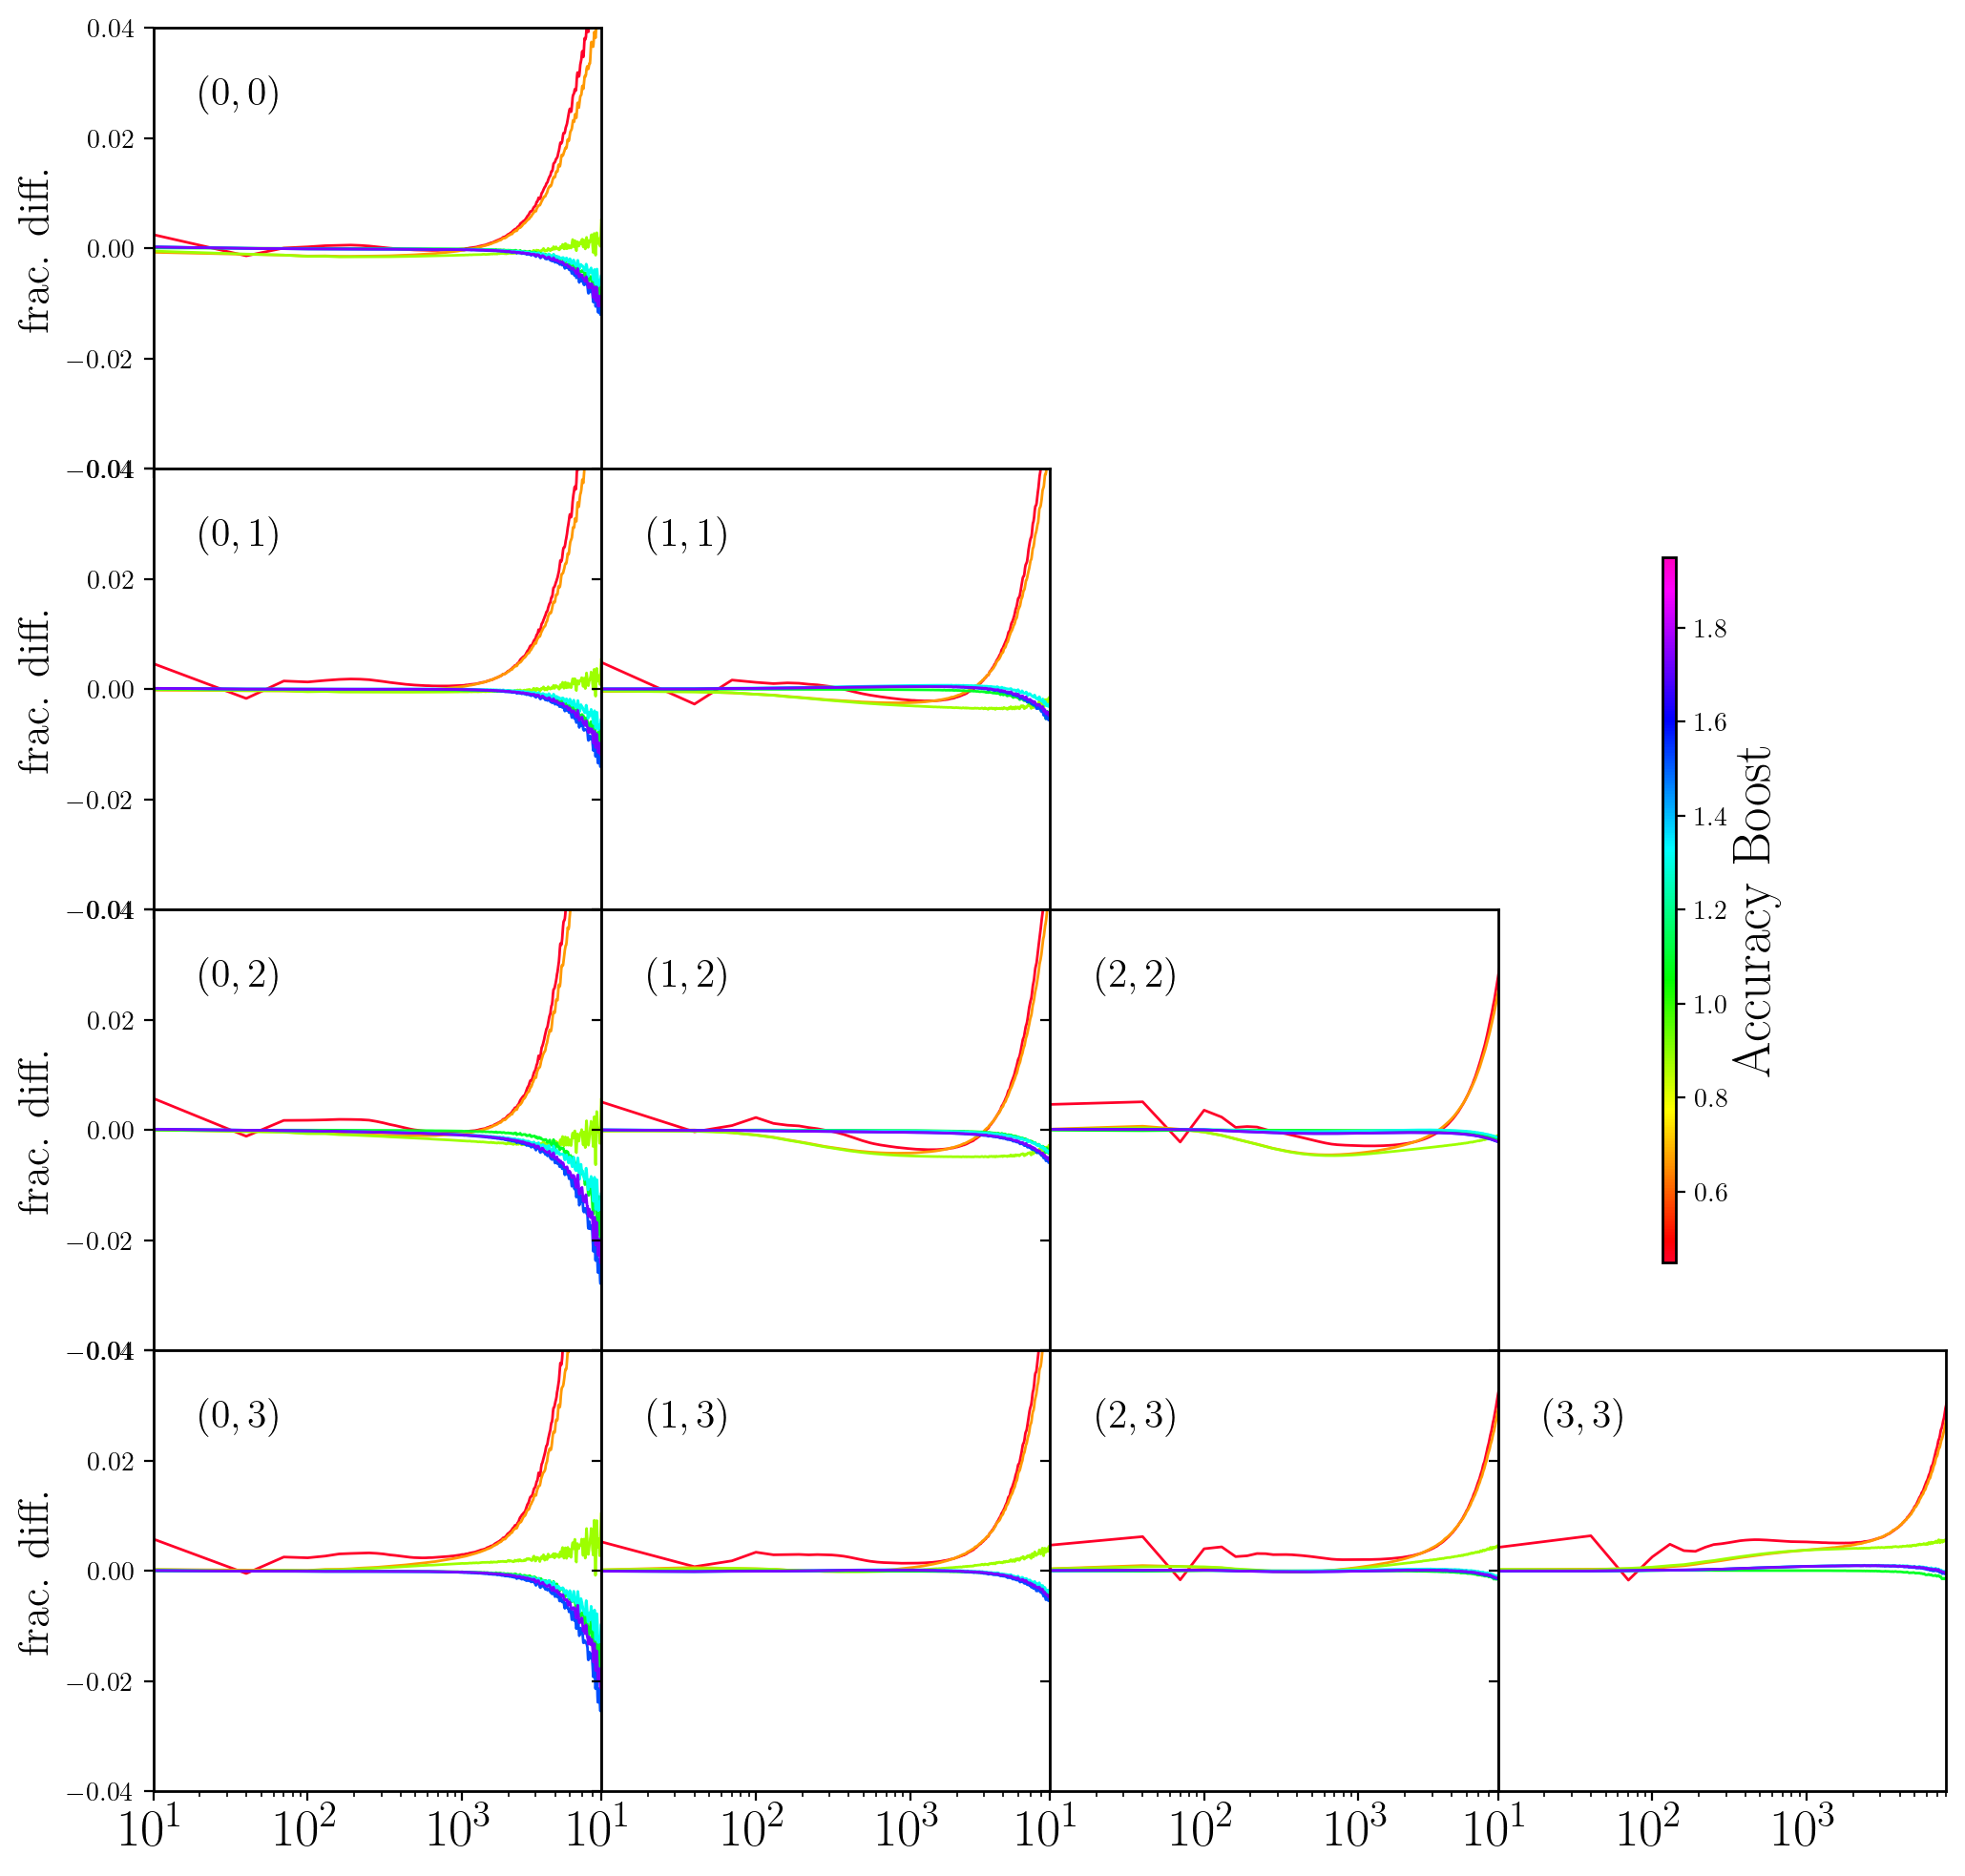

In [26]:
plot_C_ss_tomo_limber(ell=ell, C_ss=C_ss,  C_ss_ref=C_ss_ref, param=param, lmin=10, 
                      lmax=8000, ylim=(0.96,1.04),  colorbarlabel="Accuracy Boost")

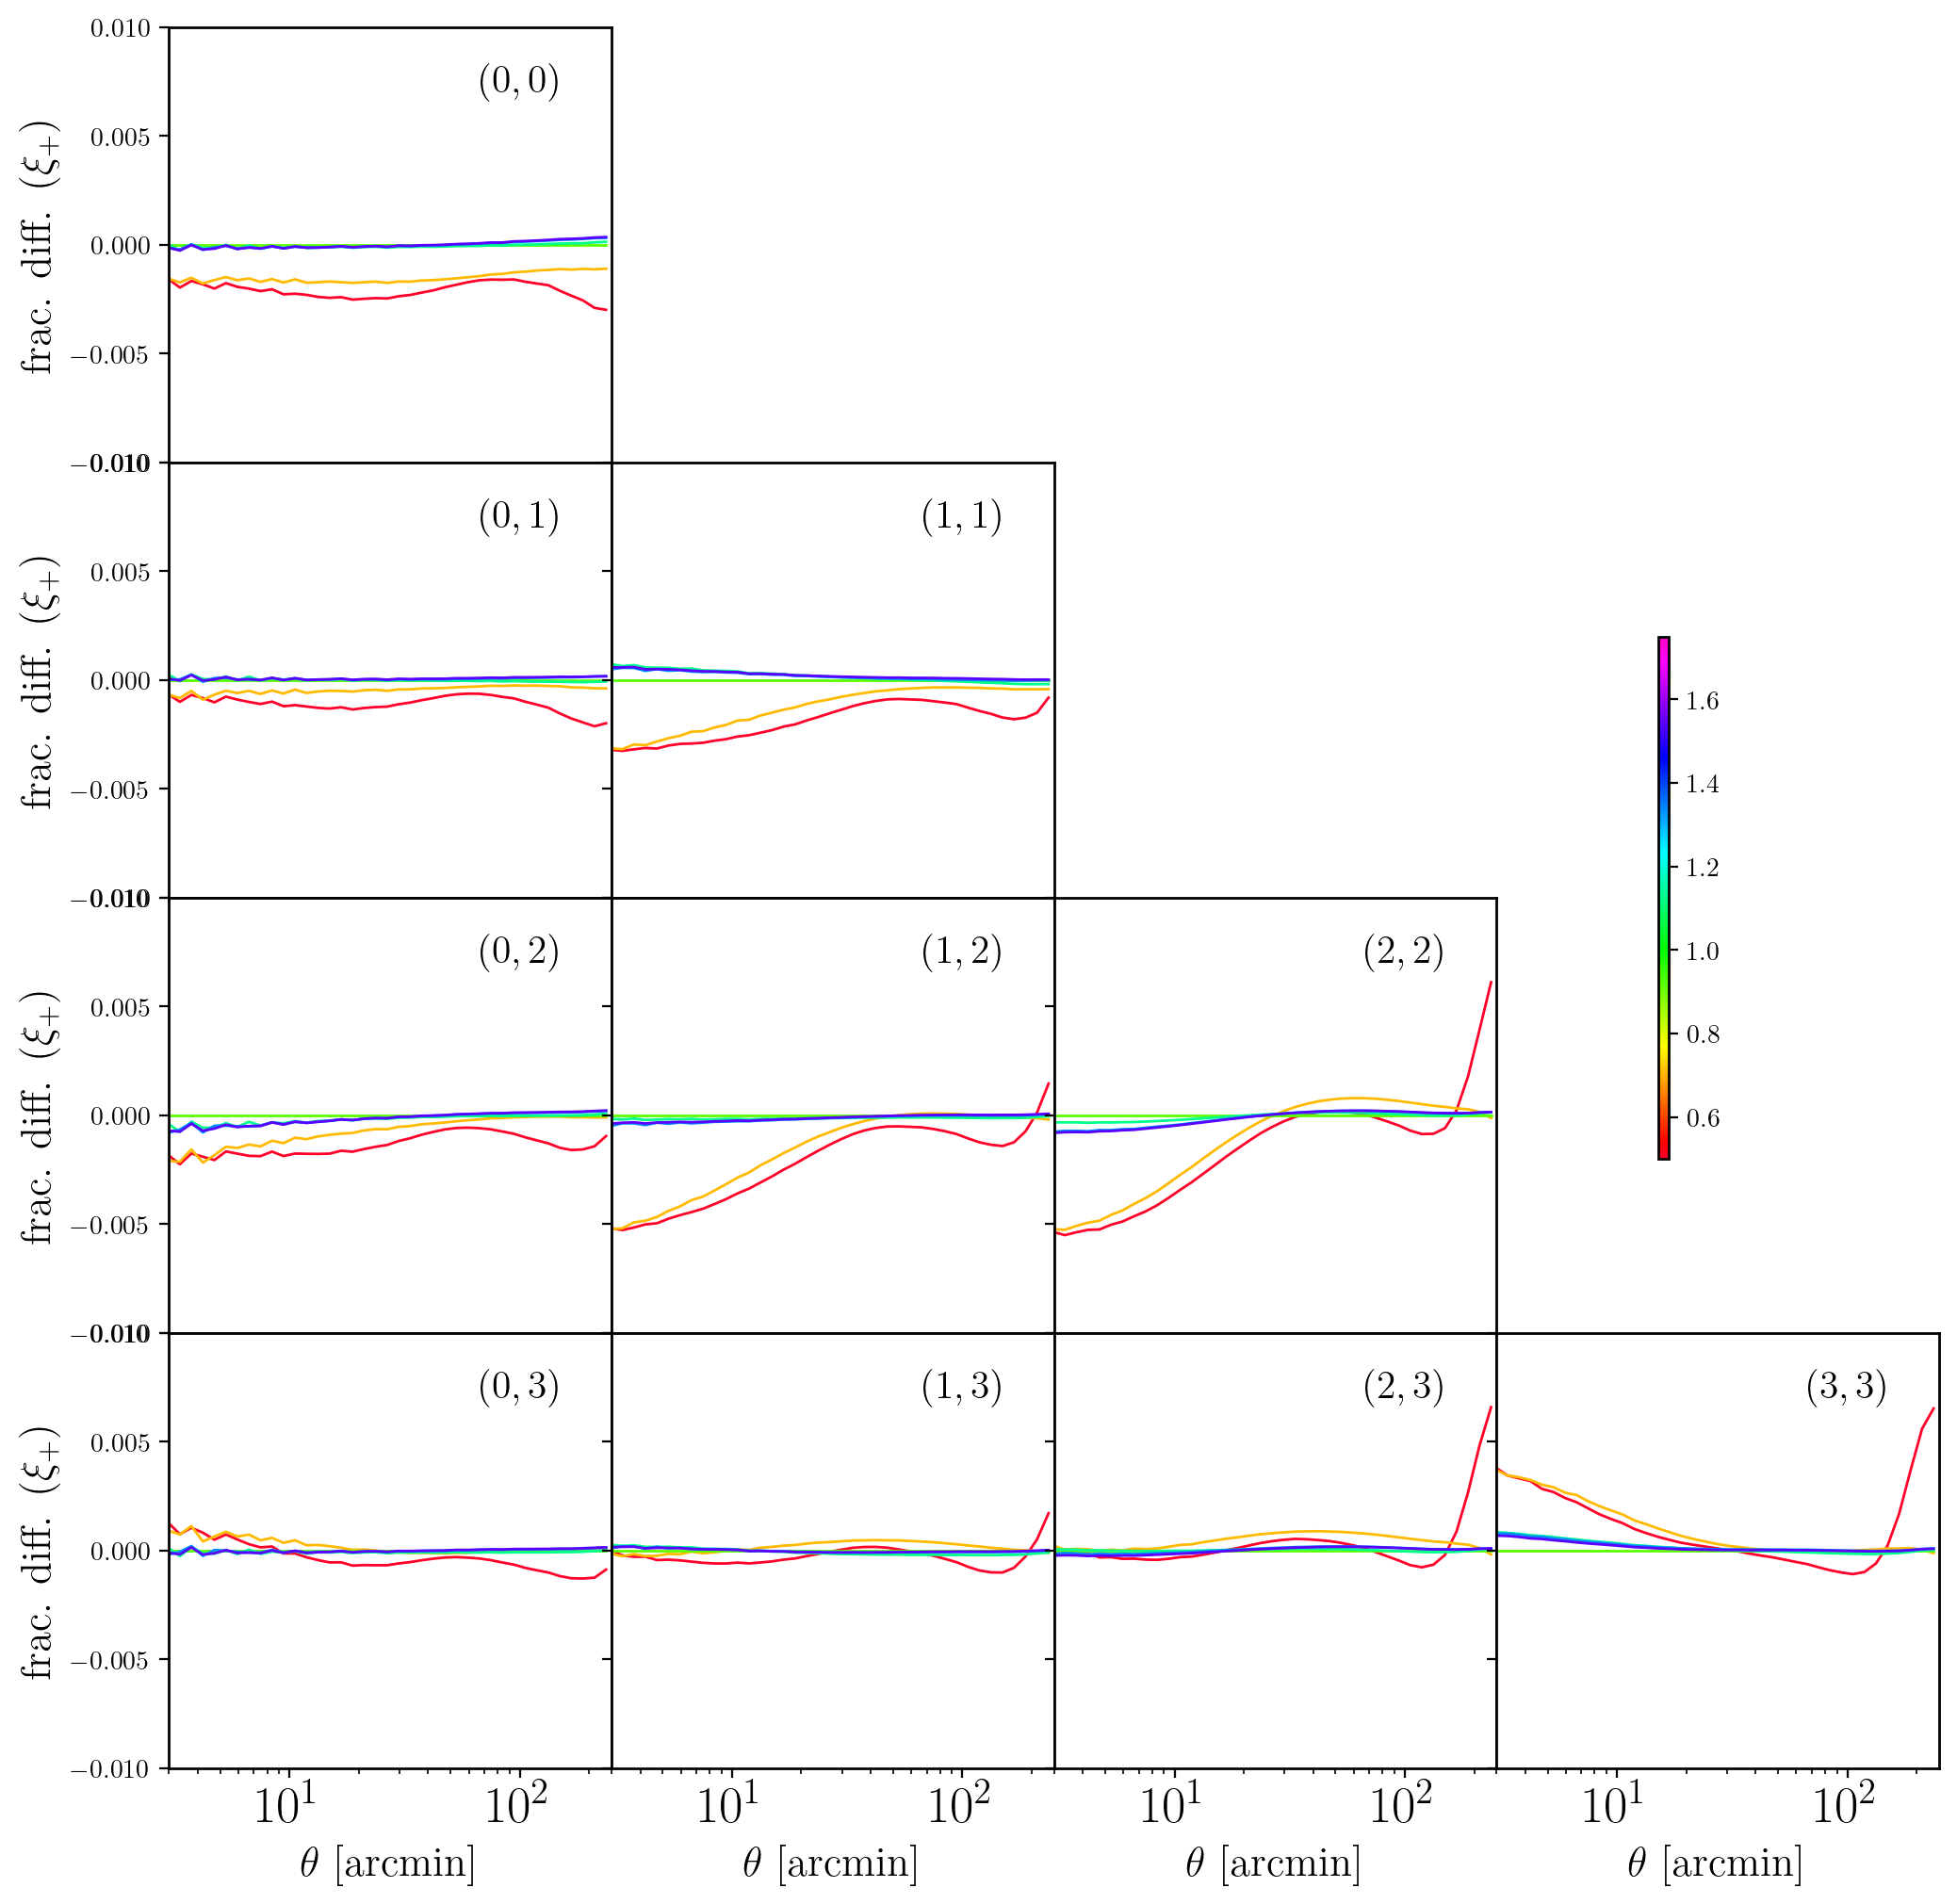

In [27]:
param = np.arange(0.5, 2.0, 0.25)
xi_theta_ref = xi(ntheta=40)

w_theta = []
for x in param:
    w_theta.append(xi(ntheta=40, AccuracyBoost=x))
    
plot_xi(pm = 1, xi = w_theta, xi_ref = xi_theta_ref, param=param, ylim=(0.99, 1.01))

# Let's compute $\chi^2_{\rm DES}$ and reproduce the results shown on EXAMPLE_EVALUATE1.YAML

In [28]:
non_linear_emul = 2
CLprobe="xi"

path= "../../external_modules/data/des_y3"
data_file="des_y3_real.dataset"

IA_model = 1
IA_redshift_evolution = 3

# Init Cosmolike & data file
ini = IniFile(os.path.normpath(os.path.join(path, data_file)))

lens_file = ini.relativeFileName('nz_lens_file')
source_file = ini.relativeFileName('nz_source_file')
lens_ntomo = ini.int("lens_ntomo")
source_ntomo = ini.int("source_ntomo")

ci.initial_setup()

ci.init_probes(possible_probes = CLprobe)

ci.init_binning(int(ini.int("n_theta")), 
                ini.float("theta_min_arcmin"), 
                ini.float("theta_max_arcmin"))


ci.init_cosmo_runmode(is_linear = False)

ci.init_IA( ia_model = int(IA_model), 
            ia_redshift_evolution = int(IA_redshift_evolution))

ci.init_redshift_distributions_from_files(
      lens_multihisto_file=ini.relativeFileName('nz_lens_file'),
      lens_ntomo=int(ini.int("lens_ntomo")), 
      source_multihisto_file=ini.relativeFileName('nz_source_file'),
      source_ntomo=int(ini.int("source_ntomo")))

ci.init_data_real(ini.relativeFileName('cov_file'), 
                  ini.relativeFileName('mask_file'), 
                  ini.relativeFileName('data_file'))

def get_chi2(omegam = omegam, 
             omegab = omegab, 
             H0 = H0, 
             ns = ns, 
             As_1e9 = As_1e9, 
             w = w, 
             w0pwa = w0pwa,
             A1  = [DES_A1_1, DES_A1_2, 0, 0], 
             A2  = [DES_A2_1, DES_A2_2, 0, 0],
             BTA = [DES_BTA_1, 0, 0, 0],
             shear_photoz_bias = [DES_DZ_S1, DES_DZ_S2, DES_DZ_S3, DES_DZ_S4],
             M = [DES_M1, DES_M2, DES_M3, DES_M4],
             baryon_sims = None,
             AccuracyBoost=1.0, 
             kmax = 10, 
             k_per_logint = 20, 
             CAMBAccuracyBoost=1.1,
             CLAccuracyBoost=1.0, 
             CLIntegrationAccuracy=1):

    CLAccuracyBoost = CLAccuracyBoost * AccuracyBoost
    CLSamplingBoost = CLAccuracyBoost * AccuracyBoost
    CLIntegrationAccuracy = max(0, CLIntegrationAccuracy + 3*(AccuracyBoost-1.0))

    ci.init_accuracy_boost(CLAccuracyBoost, CLSamplingBoost, int(CLIntegrationAccuracy))
    
    # Set Nuisance Parameters
    (log10k_interp_2D, z_interp_2D, lnPL, lnPNL, G_growth, z_interp_1D, chi) = get_camb_cosmology()
    
    ci.set_cosmology(omegam = omegam, 
                     H0 = H0, 
                     log10k_2D = log10k_interp_2D, 
                     z_2D = z_interp_2D, 
                     lnP_linear = lnPL,
                     lnP_nonlinear = lnPNL,
                     G = G_growth,
                     z_1D = z_interp_1D,
                     chi = chi)
    
    ci.set_nuisance_shear_calib(M = M)
    
    ci.set_nuisance_shear_photoz(bias = shear_photoz_bias)
    
    ci.set_nuisance_ia(A1 = A1, 
                       A2 = A2, 
                       B_TA = BTA)
    
    # Compute chi2 - just to check we can reproduce EXAMPLE_EVALUATE1.yaml
    datavector = np.array(ci.compute_data_vector_masked())
    return ci.compute_chi2(datavector)

In [29]:
print(rf"$\chi^2$={get_chi2():3.3f}")

$\chi^2$=593.244


# Let's compute $\chi^2_{\rm DES}$ as function of CLIntegrationAccuracy

In [30]:
param = np.arange(0, 10, 1)      
chi2 = []
for x in param:
    chi2.append(get_chi2(CLIntegrationAccuracy = x))
chi2 = np.array(chi2)
chi2 = chi2 - chi2[0]

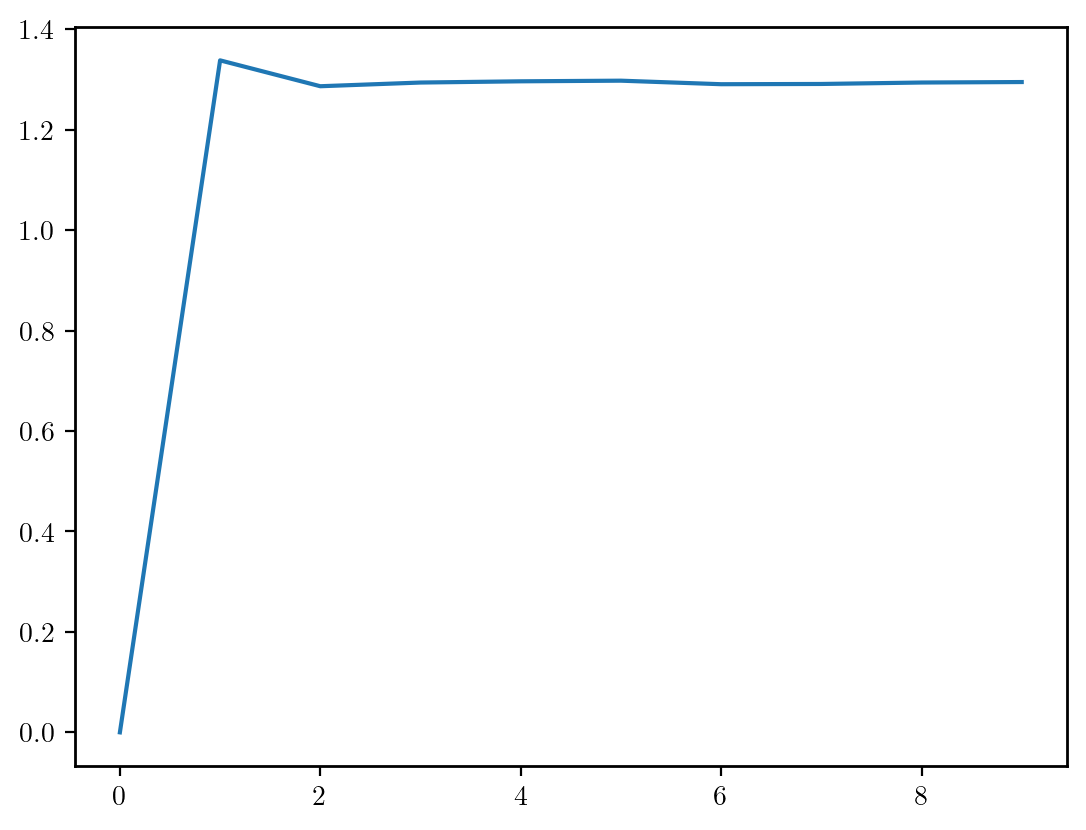

In [31]:
plt.plot(param, np.array(chi2))

# Let's compute $\chi^2_{\rm DES}$ as function of Cosmolike AccuracyBoost (Integration Accuracy = 1)

In [32]:
param = np.arange(1, 10, 1)      
chi2 = []
for x in param:
    chi2.append(get_chi2(CLAccuracyBoost=x, CLIntegrationAccuracy = 1))
chi2 = np.array(chi2)
chi2 = chi2 - chi2[0]

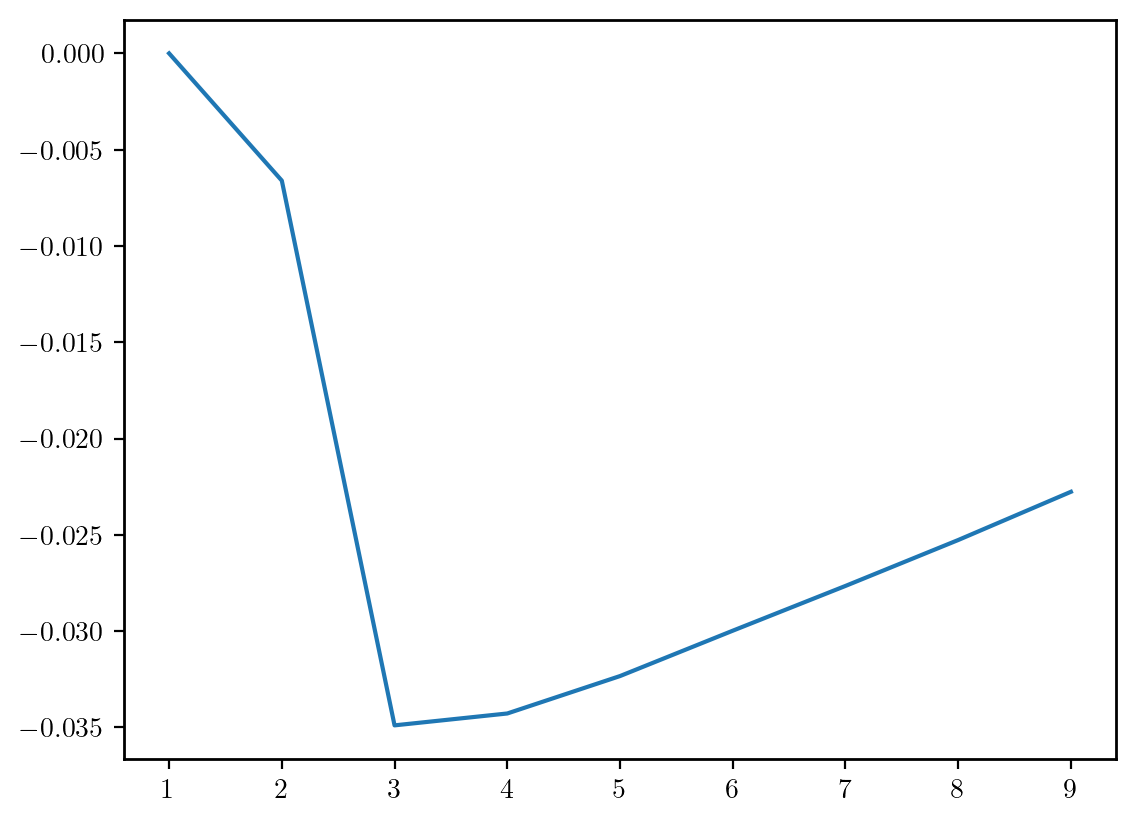

In [33]:
plt.plot(param, np.array(chi2))